In [16]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import pandas as pd
import tarfile
from tqdm import tqdm
import cv2
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

In [17]:
ATTRS_NAME = "../data/lfw_attributes.txt"

IMAGES_NAME = "../data/lfw-deepfunneled.tgz"

RAW_IMAGES_NAME = "../data/lfw.tgz"

In [18]:
def decode_image_from_raw_bytes(raw_bytes):
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [19]:
def load_lfw_dataset(
        use_raw=False,
        dx=80, dy=80,
        dimx=45, dimy=45):

    # Read attrs
    df_attrs = pd.read_csv(ATTRS_NAME, sep='\t', skiprows=1)
    df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns=df_attrs.columns[1:])
    df_attrs.head()
    imgs_with_attrs = set(map(tuple, df_attrs[["person", "imagenum"]].values))

    # Read photos
    all_photos = []
    photo_ids = []


    # Read attrs
    df_attrs = pd.read_csv(ATTRS_NAME, sep='\t', skiprows=1)
    df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns=df_attrs.columns[1:])
    df_attrs.head()
    with tarfile.open(RAW_IMAGES_NAME if use_raw else IMAGES_NAME) as f:
        for m in f.getmembers():
            # Only process image files from the compressed data
            print(m)
            if m.isfile() and m.name.endswith(".jpg"):
                # Prepare image
                img = decode_image_from_raw_bytes(f.extractfile(m).read())

                # Crop only faces and resize it
                img = img[dy:-dy, dx:-dx]
                img = cv2.resize(img, (dimx, dimy))

                # Parse person and append it to the collected data
                fname = os.path.split(m.name)[-1]
                fname_splitted = fname[:-4].replace('_', ' ').split()
                person_id = ' '.join(fname_splitted[:-1])
                photo_number = int(fname_splitted[-1])
                if (person_id, photo_number) in imgs_with_attrs:
                    all_photos.append(img)
                    photo_ids.append({'person': person_id, 'imagenum': photo_number})

    photo_ids = pd.DataFrame(photo_ids)
    all_photos = np.stack(all_photos).astype('uint8')

    # Preserve photo_ids order!
    all_attrs = photo_ids.merge(df_attrs, on=('person', 'imagenum')).drop(["person", "imagenum"], axis=1)

    return all_photos, all_attrs

In [20]:
X, attr = load_lfw_dataset(use_raw=True, dimx=32, dimy=32)

<TarInfo 'lfw' at 0x7fcef0752390>
<TarInfo 'lfw/George_HW_Bush' at 0x7fcef0752530>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0001.jpg' at 0x7fcef07522c0>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0002.jpg' at 0x7fcef0752460>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0003.jpg' at 0x7fcef0752600>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0004.jpg' at 0x7fcef07527a0>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0005.jpg' at 0x7fcef0752870>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0006.jpg' at 0x7fcef0752940>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0007.jpg' at 0x7fcef0752a10>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0008.jpg' at 0x7fcef0752ae0>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0009.jpg' at 0x7fcef0752bb0>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0010.jpg' at 0x7fcef0752c80>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0011.jpg' at 0x7fcef0752d50>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0012.jpg' at 0x7fcef0752e20>
<TarInfo 'lfw/George_HW_Bush/George_HW_Bu

<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0054.jpg' at 0x7fcd546b0a10>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0055.jpg' at 0x7fcd546b0ae0>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0056.jpg' at 0x7fcd546b0bb0>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0057.jpg' at 0x7fcd546b0c80>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0058.jpg' at 0x7fcd546b0d50>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0059.jpg' at 0x7fcd546b0e20>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0060.jpg' at 0x7fcd546b0ef0>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0061.jpg' at 0x7fcd546b0050>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0062.jpg' at 0x7fcd546b5120>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0063.jpg' at 0x7fcd546b51f0>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0064.jpg' at 0x7fcd546b52c0>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_0065.jpg' at 0x7fcd546b5390>
<TarInfo 'lfw/Gerhard_Schroeder/Gerhard_Schroeder_00

<TarInfo 'lfw/George_W_Bush/George_W_Bush_0039.jpg' at 0x7fcd544e7ef0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0040.jpg' at 0x7fcd544e7050>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0041.jpg' at 0x7fcd544ec120>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0042.jpg' at 0x7fcd544ec1f0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0043.jpg' at 0x7fcd544ec2c0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0044.jpg' at 0x7fcd544ec390>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0045.jpg' at 0x7fcd544ec460>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0046.jpg' at 0x7fcd544ec530>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0047.jpg' at 0x7fcd544ec600>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0048.jpg' at 0x7fcd544ec6d0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0049.jpg' at 0x7fcd544ec7a0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0050.jpg' at 0x7fcd544ec870>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0051.jpg' at 0x7fcd544ec940>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0052.jpg' at 0x7fcd544eca10>
<TarIn

<TarInfo 'lfw/George_W_Bush/George_W_Bush_0250.jpg' at 0x7fcd5449d120>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0251.jpg' at 0x7fcd5449d1f0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0252.jpg' at 0x7fcd5449d2c0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0253.jpg' at 0x7fcd5449d390>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0254.jpg' at 0x7fcd5449d460>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0255.jpg' at 0x7fcd5449d530>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0256.jpg' at 0x7fcd5449d600>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0257.jpg' at 0x7fcd5449d6d0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0258.jpg' at 0x7fcd5449d7a0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0259.jpg' at 0x7fcd5449d870>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0260.jpg' at 0x7fcd5449d940>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0261.jpg' at 0x7fcd5449da10>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0262.jpg' at 0x7fcd5449dae0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0263.jpg' at 0x7fcd5449dbb0>
<TarIn

<TarInfo 'lfw/George_W_Bush/George_W_Bush_0491.jpg' at 0x7fcd54450bb0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0492.jpg' at 0x7fcd54450c80>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0493.jpg' at 0x7fcd54450d50>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0494.jpg' at 0x7fcd54450e20>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0495.jpg' at 0x7fcd54450ef0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0496.jpg' at 0x7fcd54450050>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0497.jpg' at 0x7fcd54454120>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0498.jpg' at 0x7fcd544541f0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0499.jpg' at 0x7fcd544542c0>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0500.jpg' at 0x7fcd54454390>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0501.jpg' at 0x7fcd54454460>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0502.jpg' at 0x7fcd54454530>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0503.jpg' at 0x7fcd54454600>
<TarInfo 'lfw/George_W_Bush/George_W_Bush_0504.jpg' at 0x7fcd544546d0>
<TarIn

<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0097.jpg' at 0x7fcd5440cef0>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0098.jpg' at 0x7fcd5440c050>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0099.jpg' at 0x7fcd54410120>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0100.jpg' at 0x7fcd544101f0>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0101.jpg' at 0x7fcd544102c0>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0102.jpg' at 0x7fcd54410390>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0103.jpg' at 0x7fcd54410460>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0104.jpg' at 0x7fcd54410530>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0105.jpg' at 0x7fcd54410600>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0106.jpg' at 0x7fcd544106d0>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0107.jpg' at 0x7fcd544107a0>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0108.jpg' at 0x7fcd54410870>
<TarInfo 'lfw/Donald_Rumsfeld/Donald_Rumsfeld_0109.jpg' at 0x7fcd54410940>
<TarInfo 'lfw/Donald_Rums

<TarInfo 'lfw/Junichiro_Koizumi/Junichiro_Koizumi_0021.jpg' at 0x7fcd543cd1f0>
<TarInfo 'lfw/Junichiro_Koizumi/Junichiro_Koizumi_0022.jpg' at 0x7fcd543cd2c0>
<TarInfo 'lfw/Junichiro_Koizumi/Junichiro_Koizumi_0023.jpg' at 0x7fcd543cd390>
<TarInfo 'lfw/Junichiro_Koizumi/Junichiro_Koizumi_0024.jpg' at 0x7fcd543cd460>
<TarInfo 'lfw/Junichiro_Koizumi/Junichiro_Koizumi_0025.jpg' at 0x7fcd543cd530>
<TarInfo 'lfw/Junichiro_Koizumi/Junichiro_Koizumi_0026.jpg' at 0x7fcd543cd600>
<TarInfo 'lfw/Junichiro_Koizumi/Junichiro_Koizumi_0027.jpg' at 0x7fcd543cd6d0>
<TarInfo 'lfw/Junichiro_Koizumi/Junichiro_Koizumi_0028.jpg' at 0x7fcd543cd7a0>
<TarInfo 'lfw/Junichiro_Koizumi/Junichiro_Koizumi_0029.jpg' at 0x7fcd543cd870>
<TarInfo 'lfw/Junichiro_Koizumi/Junichiro_Koizumi_0030.jpg' at 0x7fcd543cd940>
<TarInfo 'lfw/Junichiro_Koizumi/Junichiro_Koizumi_0031.jpg' at 0x7fcd543cda10>
<TarInfo 'lfw/Junichiro_Koizumi/Junichiro_Koizumi_0032.jpg' at 0x7fcd543cdae0>
<TarInfo 'lfw/Junichiro_Koizumi/Junichiro_Koizumi_00

<TarInfo 'lfw/Bill_Simon/Bill_Simon_0006.jpg' at 0x7fcd543881f0>
<TarInfo 'lfw/Bill_Simon/Bill_Simon_0007.jpg' at 0x7fcd543882c0>
<TarInfo 'lfw/Bill_Simon/Bill_Simon_0008.jpg' at 0x7fcd54388390>
<TarInfo 'lfw/Bill_Simon/Bill_Simon_0009.jpg' at 0x7fcd54388460>
<TarInfo 'lfw/Bill_Simon/Bill_Simon_0010.jpg' at 0x7fcd54388530>
<TarInfo 'lfw/Bill_Simon/Bill_Simon_0011.jpg' at 0x7fcd54388600>
<TarInfo 'lfw/Bill_Simon/Bill_Simon_0012.jpg' at 0x7fcd543886d0>
<TarInfo 'lfw/Bill_Simon/Bill_Simon_0013.jpg' at 0x7fcd543887a0>
<TarInfo 'lfw/Bill_Simon/Bill_Simon_0014.jpg' at 0x7fcd54388870>
<TarInfo 'lfw/Bill_Simon/Bill_Simon_0015.jpg' at 0x7fcd54388940>
<TarInfo 'lfw/Goran_Persson' at 0x7fcd54388a10>
<TarInfo 'lfw/Goran_Persson/Goran_Persson_0001.jpg' at 0x7fcd54388ae0>
<TarInfo 'lfw/Goran_Persson/Goran_Persson_0002.jpg' at 0x7fcd54388050>
<TarInfo 'lfw/Clint_Howard' at 0x7fcd54388c80>
<TarInfo 'lfw/Clint_Howard/Clint_Howard_0001.jpg' at 0x7fcd54388d50>
<TarInfo 'lfw/Maria_Conchita_Alonso' at 0x7f

<TarInfo 'lfw/Ray_Romano/Ray_Romano_0007.jpg' at 0x7fcd5433bae0>
<TarInfo 'lfw/Ray_Romano/Ray_Romano_0008.jpg' at 0x7fcd5433bbb0>
<TarInfo 'lfw/Ray_Romano/Ray_Romano_0009.jpg' at 0x7fcd5433bc80>
<TarInfo 'lfw/Robert_Torricelli' at 0x7fcd5433bd50>
<TarInfo 'lfw/Robert_Torricelli/Robert_Torricelli_0001.jpg' at 0x7fcd5433be20>
<TarInfo 'lfw/Robert_Torricelli/Robert_Torricelli_0002.jpg' at 0x7fcd5433b6d0>
<TarInfo 'lfw/Robert_Torricelli/Robert_Torricelli_0003.jpg' at 0x7fcd5433bef0>
<TarInfo 'lfw/Amer_al-Saadi' at 0x7fcd54341120>
<TarInfo 'lfw/Amer_al-Saadi/Amer_al-Saadi_0001.jpg' at 0x7fcd543411f0>
<TarInfo 'lfw/Amer_al-Saadi/Amer_al-Saadi_0002.jpg' at 0x7fcd54341050>
<TarInfo 'lfw/Amer_al-Saadi/Amer_al-Saadi_0003.jpg' at 0x7fcd54341390>
<TarInfo 'lfw/Amer_al-Saadi/Amer_al-Saadi_0004.jpg' at 0x7fcd54341460>
<TarInfo 'lfw/Carlo_Ancelotti' at 0x7fcd54341530>
<TarInfo 'lfw/Carlo_Ancelotti/Carlo_Ancelotti_0001.jpg' at 0x7fcd54341600>
<TarInfo 'lfw/Carlo_Ancelotti/Carlo_Ancelotti_0002.jpg' at 

<TarInfo 'lfw/Mohammad_Khatami/Mohammad_Khatami_0006.jpg' at 0x7fcd54375a10>
<TarInfo 'lfw/Mohammad_Khatami/Mohammad_Khatami_0007.jpg' at 0x7fcd54375ae0>
<TarInfo 'lfw/Mohammad_Khatami/Mohammad_Khatami_0008.jpg' at 0x7fcd54375bb0>
<TarInfo 'lfw/Mohammad_Khatami/Mohammad_Khatami_0009.jpg' at 0x7fcd54375c80>
<TarInfo 'lfw/Mohammad_Khatami/Mohammad_Khatami_0010.jpg' at 0x7fcd54375d50>
<TarInfo 'lfw/Colin_Powell' at 0x7fcd54375e20>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0001.jpg' at 0x7fcd54375ef0>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0002.jpg' at 0x7fcd543756d0>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0003.jpg' at 0x7fcd542f9050>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0004.jpg' at 0x7fcd542f9120>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0005.jpg' at 0x7fcd542f92c0>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0006.jpg' at 0x7fcd542f9390>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0007.jpg' at 0x7fcd542f9460>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0008.jpg' at 0x7fcd542f9530>
<TarInfo 'lfw/Co

<TarInfo 'lfw/Colin_Powell/Colin_Powell_0216.jpg' at 0x7fcd54329460>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0217.jpg' at 0x7fcd54329530>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0218.jpg' at 0x7fcd54329600>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0219.jpg' at 0x7fcd543296d0>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0220.jpg' at 0x7fcd543297a0>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0221.jpg' at 0x7fcd54329870>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0222.jpg' at 0x7fcd54329940>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0223.jpg' at 0x7fcd54329a10>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0224.jpg' at 0x7fcd54329ae0>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0225.jpg' at 0x7fcd54329bb0>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0226.jpg' at 0x7fcd54329c80>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0227.jpg' at 0x7fcd54329d50>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0228.jpg' at 0x7fcd54329e20>
<TarInfo 'lfw/Colin_Powell/Colin_Powell_0229.jpg' at 0x7fcd54329ef0>
<TarInfo 'lfw/Colin_Powell/Colin_P

<TarInfo 'lfw/Serena_Williams/Serena_Williams_0032.jpg' at 0x7fcd542e3600>
<TarInfo 'lfw/Serena_Williams/Serena_Williams_0033.jpg' at 0x7fcd542e36d0>
<TarInfo 'lfw/Serena_Williams/Serena_Williams_0034.jpg' at 0x7fcd542e37a0>
<TarInfo 'lfw/Serena_Williams/Serena_Williams_0035.jpg' at 0x7fcd542e3870>
<TarInfo 'lfw/Serena_Williams/Serena_Williams_0036.jpg' at 0x7fcd542e3940>
<TarInfo 'lfw/Serena_Williams/Serena_Williams_0037.jpg' at 0x7fcd542e3a10>
<TarInfo 'lfw/Serena_Williams/Serena_Williams_0038.jpg' at 0x7fcd542e3ae0>
<TarInfo 'lfw/Serena_Williams/Serena_Williams_0039.jpg' at 0x7fcd542e3bb0>
<TarInfo 'lfw/Serena_Williams/Serena_Williams_0040.jpg' at 0x7fcd542e3c80>
<TarInfo 'lfw/Serena_Williams/Serena_Williams_0041.jpg' at 0x7fcd542e3d50>
<TarInfo 'lfw/Serena_Williams/Serena_Williams_0042.jpg' at 0x7fcd542e3e20>
<TarInfo 'lfw/Serena_Williams/Serena_Williams_0043.jpg' at 0x7fcd542e3ef0>
<TarInfo 'lfw/Serena_Williams/Serena_Williams_0044.jpg' at 0x7fcd542e3050>
<TarInfo 'lfw/Serena_Will

<TarInfo 'lfw/Fernando_Henrique_Cardoso' at 0x7fcd5429cc80>
<TarInfo 'lfw/Fernando_Henrique_Cardoso/Fernando_Henrique_Cardoso_0001.jpg' at 0x7fcd5429cd50>
<TarInfo 'lfw/Fernando_Henrique_Cardoso/Fernando_Henrique_Cardoso_0002.jpg' at 0x7fcd5429c7a0>
<TarInfo 'lfw/Fernando_Henrique_Cardoso/Fernando_Henrique_Cardoso_0003.jpg' at 0x7fcd5429cef0>
<TarInfo 'lfw/Fernando_Henrique_Cardoso/Fernando_Henrique_Cardoso_0004.jpg' at 0x7fcd5429ce20>
<TarInfo 'lfw/Fernando_Henrique_Cardoso/Fernando_Henrique_Cardoso_0005.jpg' at 0x7fcd542a1120>
<TarInfo 'lfw/Fernando_Henrique_Cardoso/Fernando_Henrique_Cardoso_0006.jpg' at 0x7fcd542a11f0>
<TarInfo 'lfw/Fernando_Henrique_Cardoso/Fernando_Henrique_Cardoso_0007.jpg' at 0x7fcd542a12c0>
<TarInfo 'lfw/Fernando_Henrique_Cardoso/Fernando_Henrique_Cardoso_0008.jpg' at 0x7fcd542a1390>
<TarInfo 'lfw/Alvaro_Uribe' at 0x7fcd542a1460>
<TarInfo 'lfw/Alvaro_Uribe/Alvaro_Uribe_0001.jpg' at 0x7fcd542a1530>
<TarInfo 'lfw/Alvaro_Uribe/Alvaro_Uribe_0002.jpg' at 0x7fcd542a1

<TarInfo 'lfw/Stephen_Arigbabu' at 0x7fcd54257ae0>
<TarInfo 'lfw/Stephen_Arigbabu/Stephen_Arigbabu_0001.jpg' at 0x7fcd54257d50>
<TarInfo 'lfw/Boris_Becker' at 0x7fcd54257c80>
<TarInfo 'lfw/Boris_Becker/Boris_Becker_0001.jpg' at 0x7fcd54257ef0>
<TarInfo 'lfw/Boris_Becker/Boris_Becker_0002.jpg' at 0x7fcd54257e20>
<TarInfo 'lfw/Boris_Becker/Boris_Becker_0003.jpg' at 0x7fcd5425d050>
<TarInfo 'lfw/Boris_Becker/Boris_Becker_0004.jpg' at 0x7fcd5425d1f0>
<TarInfo 'lfw/Boris_Becker/Boris_Becker_0005.jpg' at 0x7fcd5425d2c0>
<TarInfo 'lfw/Boris_Becker/Boris_Becker_0006.jpg' at 0x7fcd5425d390>
<TarInfo 'lfw/Deepa_Mehta' at 0x7fcd5425d460>
<TarInfo 'lfw/Deepa_Mehta/Deepa_Mehta_0001.jpg' at 0x7fcd5425d530>
<TarInfo 'lfw/Terry_Gilliam' at 0x7fcd5425d120>
<TarInfo 'lfw/Terry_Gilliam/Terry_Gilliam_0001.jpg' at 0x7fcd5425d6d0>
<TarInfo 'lfw/Jacques_Chirac' at 0x7fcd5425d600>
<TarInfo 'lfw/Jacques_Chirac/Jacques_Chirac_0001.jpg' at 0x7fcd5425d870>
<TarInfo 'lfw/Jacques_Chirac/Jacques_Chirac_0002.jpg' at 

<TarInfo 'lfw/Michele_Placido' at 0x7fcd54214ef0>
<TarInfo 'lfw/Michele_Placido/Michele_Placido_0001.jpg' at 0x7fcd54217050>
<TarInfo 'lfw/Laura_Morante' at 0x7fcd54217120>
<TarInfo 'lfw/Laura_Morante/Laura_Morante_0001.jpg' at 0x7fcd542172c0>
<TarInfo 'lfw/Mike_Fisher' at 0x7fcd542171f0>
<TarInfo 'lfw/Mike_Fisher/Mike_Fisher_0001.jpg' at 0x7fcd54217460>
<TarInfo 'lfw/Edward_Said' at 0x7fcd54217530>
<TarInfo 'lfw/Edward_Said/Edward_Said_0001.jpg' at 0x7fcd542176d0>
<TarInfo 'lfw/Edward_Said/Edward_Said_0002.jpg' at 0x7fcd54217600>
<TarInfo 'lfw/Roseanne_Barr' at 0x7fcd542177a0>
<TarInfo 'lfw/Roseanne_Barr/Roseanne_Barr_0001.jpg' at 0x7fcd54217870>
<TarInfo 'lfw/Roseanne_Barr/Roseanne_Barr_0002.jpg' at 0x7fcd54217390>
<TarInfo 'lfw/Roseanne_Barr/Roseanne_Barr_0003.jpg' at 0x7fcd54217a10>
<TarInfo 'lfw/Vladimir_Putin' at 0x7fcd54217ae0>
<TarInfo 'lfw/Vladimir_Putin/Vladimir_Putin_0001.jpg' at 0x7fcd54217bb0>
<TarInfo 'lfw/Vladimir_Putin/Vladimir_Putin_0002.jpg' at 0x7fcd54217940>
<TarInf

<TarInfo 'lfw/Jean_Chretien/Jean_Chretien_0006.jpg' at 0x7fcd541ca460>
<TarInfo 'lfw/Jean_Chretien/Jean_Chretien_0007.jpg' at 0x7fcd541ca530>
<TarInfo 'lfw/Jean_Chretien/Jean_Chretien_0008.jpg' at 0x7fcd541ca600>
<TarInfo 'lfw/Jean_Chretien/Jean_Chretien_0009.jpg' at 0x7fcd541ca6d0>
<TarInfo 'lfw/Jean_Chretien/Jean_Chretien_0010.jpg' at 0x7fcd541ca7a0>
<TarInfo 'lfw/Jean_Chretien/Jean_Chretien_0011.jpg' at 0x7fcd541ca870>
<TarInfo 'lfw/Jean_Chretien/Jean_Chretien_0012.jpg' at 0x7fcd541ca940>
<TarInfo 'lfw/Jean_Chretien/Jean_Chretien_0013.jpg' at 0x7fcd541caa10>
<TarInfo 'lfw/Jean_Chretien/Jean_Chretien_0014.jpg' at 0x7fcd541caae0>
<TarInfo 'lfw/Jean_Chretien/Jean_Chretien_0015.jpg' at 0x7fcd541cabb0>
<TarInfo 'lfw/Jean_Chretien/Jean_Chretien_0016.jpg' at 0x7fcd541cac80>
<TarInfo 'lfw/Jean_Chretien/Jean_Chretien_0017.jpg' at 0x7fcd541cad50>
<TarInfo 'lfw/Jean_Chretien/Jean_Chretien_0018.jpg' at 0x7fcd541cae20>
<TarInfo 'lfw/Jean_Chretien/Jean_Chretien_0019.jpg' at 0x7fcd541caef0>
<TarIn

<TarInfo 'lfw/Tom_Ridge/Tom_Ridge_0002.jpg' at 0x7fcd5417cae0>
<TarInfo 'lfw/Tom_Ridge/Tom_Ridge_0003.jpg' at 0x7fcd5417cd50>
<TarInfo 'lfw/Tom_Ridge/Tom_Ridge_0004.jpg' at 0x7fcd5417ce20>
<TarInfo 'lfw/Tom_Ridge/Tom_Ridge_0005.jpg' at 0x7fcd5417cef0>
<TarInfo 'lfw/Tom_Ridge/Tom_Ridge_0006.jpg' at 0x7fcd5417cc80>
<TarInfo 'lfw/Tom_Ridge/Tom_Ridge_0007.jpg' at 0x7fcd54180120>
<TarInfo 'lfw/Tom_Ridge/Tom_Ridge_0008.jpg' at 0x7fcd541801f0>
<TarInfo 'lfw/Tom_Ridge/Tom_Ridge_0009.jpg' at 0x7fcd541802c0>
<TarInfo 'lfw/Tom_Ridge/Tom_Ridge_0010.jpg' at 0x7fcd54180390>
<TarInfo 'lfw/Tom_Ridge/Tom_Ridge_0011.jpg' at 0x7fcd54180460>
<TarInfo 'lfw/Tom_Ridge/Tom_Ridge_0012.jpg' at 0x7fcd54180530>
<TarInfo 'lfw/Tom_Ridge/Tom_Ridge_0013.jpg' at 0x7fcd54180600>
<TarInfo 'lfw/Tom_Ridge/Tom_Ridge_0014.jpg' at 0x7fcd541806d0>
<TarInfo 'lfw/Tom_Ridge/Tom_Ridge_0015.jpg' at 0x7fcd541807a0>
<TarInfo 'lfw/Tom_Ridge/Tom_Ridge_0016.jpg' at 0x7fcd54180870>
<TarInfo 'lfw/Tom_Ridge/Tom_Ridge_0017.jpg' at 0x7fcd54

<TarInfo 'lfw/Stockard_Channing' at 0x7fcd541b2940>
<TarInfo 'lfw/Stockard_Channing/Stockard_Channing_0001.jpg' at 0x7fcd541b2a10>
<TarInfo 'lfw/Stockard_Channing/Stockard_Channing_0002.jpg' at 0x7fcd541b26d0>
<TarInfo 'lfw/Stockard_Channing/Stockard_Channing_0003.jpg' at 0x7fcd541b2bb0>
<TarInfo 'lfw/Doris_Roberts' at 0x7fcd541b2c80>
<TarInfo 'lfw/Doris_Roberts/Doris_Roberts_0001.jpg' at 0x7fcd541b2d50>
<TarInfo 'lfw/Doris_Roberts/Doris_Roberts_0002.jpg' at 0x7fcd541b2ae0>
<TarInfo 'lfw/Doris_Roberts/Doris_Roberts_0003.jpg' at 0x7fcd541b2ef0>
<TarInfo 'lfw/Ranil_Wickremasinghe' at 0x7fcd541b2e20>
<TarInfo 'lfw/Ranil_Wickremasinghe/Ranil_Wickremasinghe_0001.jpg' at 0x7fcd541b7120>
<TarInfo 'lfw/Ranil_Wickremasinghe/Ranil_Wickremasinghe_0002.jpg' at 0x7fcd541b7050>
<TarInfo 'lfw/Ranil_Wickremasinghe/Ranil_Wickremasinghe_0003.jpg' at 0x7fcd541b72c0>
<TarInfo 'lfw/John_McCain' at 0x7fcd541b7390>
<TarInfo 'lfw/John_McCain/John_McCain_0001.jpg' at 0x7fcd541b7460>
<TarInfo 'lfw/John_McCain/J

<TarInfo 'lfw/Guillermo_Ortiz/Guillermo_Ortiz_0002.jpg' at 0x7fcd54176d50>
<TarInfo 'lfw/Pat_Rochester' at 0x7fcd54176ef0>
<TarInfo 'lfw/Pat_Rochester/Pat_Rochester_0001.jpg' at 0x7fcd540fa120>
<TarInfo 'lfw/Joerg_Haider' at 0x7fcd540fa050>
<TarInfo 'lfw/Joerg_Haider/Joerg_Haider_0001.jpg' at 0x7fcd540fa2c0>
<TarInfo 'lfw/Joerg_Haider/Joerg_Haider_0002.jpg' at 0x7fcd540fa1f0>
<TarInfo 'lfw/Yashwant_Sinha' at 0x7fcd540fa460>
<TarInfo 'lfw/Yashwant_Sinha/Yashwant_Sinha_0001.jpg' at 0x7fcd540fa530>
<TarInfo 'lfw/Yashwant_Sinha/Yashwant_Sinha_0002.jpg' at 0x7fcd540fa390>
<TarInfo 'lfw/Yashwant_Sinha/Yashwant_Sinha_0003.jpg' at 0x7fcd540fa6d0>
<TarInfo 'lfw/Yashwant_Sinha/Yashwant_Sinha_0004.jpg' at 0x7fcd540fa7a0>
<TarInfo 'lfw/Yashwant_Sinha/Yashwant_Sinha_0005.jpg' at 0x7fcd540fa870>
<TarInfo 'lfw/Yashwant_Sinha/Yashwant_Sinha_0006.jpg' at 0x7fcd540fa940>
<TarInfo 'lfw/Yashwant_Sinha/Yashwant_Sinha_0007.jpg' at 0x7fcd540faa10>
<TarInfo 'lfw/Ahmed_Qureia' at 0x7fcd540faae0>
<TarInfo 'lfw/

<TarInfo 'lfw/Roberto_Guaterroma' at 0x7fcd540ba530>
<TarInfo 'lfw/Roberto_Guaterroma/Roberto_Guaterroma_0001.jpg' at 0x7fcd540ba600>
<TarInfo 'lfw/Pedro_Velasquez' at 0x7fcd540ba460>
<TarInfo 'lfw/Pedro_Velasquez/Pedro_Velasquez_0001.jpg' at 0x7fcd540ba7a0>
<TarInfo 'lfw/Julia_Tymoshenko' at 0x7fcd540ba6d0>
<TarInfo 'lfw/Julia_Tymoshenko/Julia_Tymoshenko_0001.jpg' at 0x7fcd540ba940>
<TarInfo 'lfw/Julia_Tymoshenko/Julia_Tymoshenko_0002.jpg' at 0x7fcd540ba870>
<TarInfo 'lfw/Julia_Tymoshenko/Julia_Tymoshenko_0003.jpg' at 0x7fcd540baae0>
<TarInfo 'lfw/Brian_Cashman' at 0x7fcd540babb0>
<TarInfo 'lfw/Brian_Cashman/Brian_Cashman_0001.jpg' at 0x7fcd540bac80>
<TarInfo 'lfw/Joe_Plumeri' at 0x7fcd540baa10>
<TarInfo 'lfw/Joe_Plumeri/Joe_Plumeri_0001.jpg' at 0x7fcd540bae20>
<TarInfo 'lfw/Milt_Palacio' at 0x7fcd540bad50>
<TarInfo 'lfw/Milt_Palacio/Milt_Palacio_0001.jpg' at 0x7fcd540baef0>
<TarInfo 'lfw/Ellen_Barkin' at 0x7fcd540bf050>
<TarInfo 'lfw/Ellen_Barkin/Ellen_Barkin_0001.jpg' at 0x7fcd540bf

<TarInfo 'lfw/Nur_Jaafar' at 0x7fcd5407ec80>
<TarInfo 'lfw/Nur_Jaafar/Nur_Jaafar_0001.jpg' at 0x7fcd5407eef0>
<TarInfo 'lfw/Michel_Therrien' at 0x7fcd54084050>
<TarInfo 'lfw/Michel_Therrien/Michel_Therrien_0001.jpg' at 0x7fcd540841f0>
<TarInfo 'lfw/Michel_Therrien/Michel_Therrien_0002.jpg' at 0x7fcd54084120>
<TarInfo 'lfw/Jose_Theodore' at 0x7fcd54084390>
<TarInfo 'lfw/Jose_Theodore/Jose_Theodore_0001.jpg' at 0x7fcd54084460>
<TarInfo 'lfw/Jose_Theodore/Jose_Theodore_0002.jpg' at 0x7fcd540842c0>
<TarInfo 'lfw/Juan_Sanchez' at 0x7fcd54084600>
<TarInfo 'lfw/Juan_Sanchez/Juan_Sanchez_0001.jpg' at 0x7fcd540846d0>
<TarInfo 'lfw/Demetrius_Ferraciu' at 0x7fcd54084530>
<TarInfo 'lfw/Demetrius_Ferraciu/Demetrius_Ferraciu_0001.jpg' at 0x7fcd54084870>
<TarInfo 'lfw/Demetrius_Ferraciu/Demetrius_Ferraciu_0002.jpg' at 0x7fcd540847a0>
<TarInfo 'lfw/Peter_Mansbridge' at 0x7fcd54084a10>
<TarInfo 'lfw/Peter_Mansbridge/Peter_Mansbridge_0001.jpg' at 0x7fcd54084ae0>
<TarInfo 'lfw/Wilbert_Elki_Meza_Majino' a

<TarInfo 'lfw/Tom_Harkin/Tom_Harkin_0002.jpg' at 0x7fcd5404b2c0>
<TarInfo 'lfw/Tom_Harkin/Tom_Harkin_0003.jpg' at 0x7fcd5404b600>
<TarInfo 'lfw/Tom_Harkin/Tom_Harkin_0004.jpg' at 0x7fcd5404b6d0>
<TarInfo 'lfw/Tom_Harkin/Tom_Harkin_0005.jpg' at 0x7fcd5404b7a0>
<TarInfo 'lfw/Kim_Dae-jung' at 0x7fcd5404b870>
<TarInfo 'lfw/Kim_Dae-jung/Kim_Dae-jung_0001.jpg' at 0x7fcd5404b940>
<TarInfo 'lfw/Kim_Dae-jung/Kim_Dae-jung_0002.jpg' at 0x7fcd5404b530>
<TarInfo 'lfw/Kim_Dae-jung/Kim_Dae-jung_0003.jpg' at 0x7fcd5404bae0>
<TarInfo 'lfw/Kim_Dae-jung/Kim_Dae-jung_0004.jpg' at 0x7fcd5404bbb0>
<TarInfo 'lfw/Kim_Dae-jung/Kim_Dae-jung_0005.jpg' at 0x7fcd5404bc80>
<TarInfo 'lfw/Kim_Dae-jung/Kim_Dae-jung_0006.jpg' at 0x7fcd5404bd50>
<TarInfo 'lfw/Kim_Dae-jung/Kim_Dae-jung_0007.jpg' at 0x7fcd5404be20>
<TarInfo 'lfw/Kim_Dae-jung/Kim_Dae-jung_0008.jpg' at 0x7fcd5404bef0>
<TarInfo 'lfw/Tonya_Payne' at 0x7fcd5404ba10>
<TarInfo 'lfw/Tonya_Payne/Tonya_Payne_0001.jpg' at 0x7fcd54050120>
<TarInfo 'lfw/Lennox_Lewis' 

<TarInfo 'lfw/Gonzalo_Sanchez_de_Lozada' at 0x7fcd36fd57a0>
<TarInfo 'lfw/Gonzalo_Sanchez_de_Lozada/Gonzalo_Sanchez_de_Lozada_0001.jpg' at 0x7fcd36fd5ae0>
<TarInfo 'lfw/Gonzalo_Sanchez_de_Lozada/Gonzalo_Sanchez_de_Lozada_0002.jpg' at 0x7fcd36fd5a10>
<TarInfo 'lfw/Gonzalo_Sanchez_de_Lozada/Gonzalo_Sanchez_de_Lozada_0003.jpg' at 0x7fcd36fd5c80>
<TarInfo 'lfw/Gonzalo_Sanchez_de_Lozada/Gonzalo_Sanchez_de_Lozada_0004.jpg' at 0x7fcd36fd5d50>
<TarInfo 'lfw/Gonzalo_Sanchez_de_Lozada/Gonzalo_Sanchez_de_Lozada_0005.jpg' at 0x7fcd36fd5e20>
<TarInfo 'lfw/Gonzalo_Sanchez_de_Lozada/Gonzalo_Sanchez_de_Lozada_0006.jpg' at 0x7fcd36fd5ef0>
<TarInfo 'lfw/Gonzalo_Sanchez_de_Lozada/Gonzalo_Sanchez_de_Lozada_0007.jpg' at 0x7fcd36fd5bb0>
<TarInfo 'lfw/Gonzalo_Sanchez_de_Lozada/Gonzalo_Sanchez_de_Lozada_0008.jpg' at 0x7fcd36fd8120>
<TarInfo 'lfw/Gonzalo_Sanchez_de_Lozada/Gonzalo_Sanchez_de_Lozada_0009.jpg' at 0x7fcd36fd81f0>
<TarInfo 'lfw/Gonzalo_Sanchez_de_Lozada/Gonzalo_Sanchez_de_Lozada_0010.jpg' at 0x7fcd

<TarInfo 'lfw/Britney_Spears/Britney_Spears_0005.jpg' at 0x7fcd36f9c530>
<TarInfo 'lfw/Britney_Spears/Britney_Spears_0006.jpg' at 0x7fcd36f9c600>
<TarInfo 'lfw/Britney_Spears/Britney_Spears_0007.jpg' at 0x7fcd36f9c6d0>
<TarInfo 'lfw/Britney_Spears/Britney_Spears_0008.jpg' at 0x7fcd36f9c7a0>
<TarInfo 'lfw/Britney_Spears/Britney_Spears_0009.jpg' at 0x7fcd36f9c870>
<TarInfo 'lfw/Britney_Spears/Britney_Spears_0010.jpg' at 0x7fcd36f9c940>
<TarInfo 'lfw/Britney_Spears/Britney_Spears_0011.jpg' at 0x7fcd36f9ca10>
<TarInfo 'lfw/Britney_Spears/Britney_Spears_0012.jpg' at 0x7fcd36f9cae0>
<TarInfo 'lfw/Britney_Spears/Britney_Spears_0013.jpg' at 0x7fcd36f9cbb0>
<TarInfo 'lfw/Britney_Spears/Britney_Spears_0014.jpg' at 0x7fcd36f9cc80>
<TarInfo 'lfw/Franz_Fischler' at 0x7fcd36f9cd50>
<TarInfo 'lfw/Franz_Fischler/Franz_Fischler_0001.jpg' at 0x7fcd36f9ce20>
<TarInfo 'lfw/Franz_Fischler/Franz_Fischler_0002.jpg' at 0x7fcd36f9c2c0>
<TarInfo 'lfw/Franz_Fischler/Franz_Fischler_0003.jpg' at 0x7fcd36f9cef0>
<T

<TarInfo 'lfw/Eduardo_Duhalde/Eduardo_Duhalde_0012.jpg' at 0x7fcd36f5b7a0>
<TarInfo 'lfw/Eduardo_Duhalde/Eduardo_Duhalde_0013.jpg' at 0x7fcd36f5f120>
<TarInfo 'lfw/Eduardo_Duhalde/Eduardo_Duhalde_0014.jpg' at 0x7fcd36f5f1f0>
<TarInfo 'lfw/Jon_Kitna' at 0x7fcd36f5f2c0>
<TarInfo 'lfw/Jon_Kitna/Jon_Kitna_0001.jpg' at 0x7fcd36f5f390>
<TarInfo 'lfw/Bob_Cantrell' at 0x7fcd36f5f050>
<TarInfo 'lfw/Bob_Cantrell/Bob_Cantrell_0001.jpg' at 0x7fcd36f5f530>
<TarInfo 'lfw/Chan_Ho_Park' at 0x7fcd36f5f460>
<TarInfo 'lfw/Chan_Ho_Park/Chan_Ho_Park_0001.jpg' at 0x7fcd36f5f6d0>
<TarInfo 'lfw/Warren_Truss' at 0x7fcd36f5f600>
<TarInfo 'lfw/Warren_Truss/Warren_Truss_0001.jpg' at 0x7fcd36f5f870>
<TarInfo 'lfw/Michel_Charles_Chretien' at 0x7fcd36f5f7a0>
<TarInfo 'lfw/Michel_Charles_Chretien/Michel_Charles_Chretien_0001.jpg' at 0x7fcd36f5fa10>
<TarInfo 'lfw/Brian_Schneider' at 0x7fcd36f5f940>
<TarInfo 'lfw/Brian_Schneider/Brian_Schneider_0001.jpg' at 0x7fcd36f5fbb0>
<TarInfo 'lfw/Clay_Campbell' at 0x7fcd36f5fae0

<TarInfo 'lfw/OJ_Simpson' at 0x7fcd36f291f0>
<TarInfo 'lfw/OJ_Simpson/OJ_Simpson_0001.jpg' at 0x7fcd36f292c0>
<TarInfo 'lfw/OJ_Simpson/OJ_Simpson_0002.jpg' at 0x7fcd36f29050>
<TarInfo 'lfw/Charles_Schumer' at 0x7fcd36f29460>
<TarInfo 'lfw/Charles_Schumer/Charles_Schumer_0001.jpg' at 0x7fcd36f29530>
<TarInfo 'lfw/Charles_Schumer/Charles_Schumer_0002.jpg' at 0x7fcd36f29390>
<TarInfo 'lfw/James_Blake' at 0x7fcd36f296d0>
<TarInfo 'lfw/James_Blake/James_Blake_0001.jpg' at 0x7fcd36f297a0>
<TarInfo 'lfw/James_Blake/James_Blake_0002.jpg' at 0x7fcd36f29600>
<TarInfo 'lfw/James_Blake/James_Blake_0003.jpg' at 0x7fcd36f29940>
<TarInfo 'lfw/James_Blake/James_Blake_0004.jpg' at 0x7fcd36f29a10>
<TarInfo 'lfw/James_Blake/James_Blake_0005.jpg' at 0x7fcd36f29ae0>
<TarInfo 'lfw/James_Blake/James_Blake_0006.jpg' at 0x7fcd36f29bb0>
<TarInfo 'lfw/James_Blake/James_Blake_0007.jpg' at 0x7fcd36f29c80>
<TarInfo 'lfw/James_Blake/James_Blake_0008.jpg' at 0x7fcd36f29d50>
<TarInfo 'lfw/James_Blake/James_Blake_0009.

<TarInfo 'lfw/Richard_Myers/Richard_Myers_0002.jpg' at 0x7fcd36eea050>
<TarInfo 'lfw/Richard_Myers/Richard_Myers_0003.jpg' at 0x7fcd36eea6d0>
<TarInfo 'lfw/Richard_Myers/Richard_Myers_0004.jpg' at 0x7fcd36eea7a0>
<TarInfo 'lfw/Richard_Myers/Richard_Myers_0005.jpg' at 0x7fcd36eea870>
<TarInfo 'lfw/Richard_Myers/Richard_Myers_0006.jpg' at 0x7fcd36eea940>
<TarInfo 'lfw/Richard_Myers/Richard_Myers_0007.jpg' at 0x7fcd36eeaa10>
<TarInfo 'lfw/Richard_Myers/Richard_Myers_0008.jpg' at 0x7fcd36eeaae0>
<TarInfo 'lfw/Richard_Myers/Richard_Myers_0009.jpg' at 0x7fcd36eeabb0>
<TarInfo 'lfw/Richard_Myers/Richard_Myers_0010.jpg' at 0x7fcd36eeac80>
<TarInfo 'lfw/Richard_Myers/Richard_Myers_0011.jpg' at 0x7fcd36eead50>
<TarInfo 'lfw/Richard_Myers/Richard_Myers_0012.jpg' at 0x7fcd36eeae20>
<TarInfo 'lfw/Richard_Myers/Richard_Myers_0013.jpg' at 0x7fcd36eeaef0>
<TarInfo 'lfw/Richard_Myers/Richard_Myers_0014.jpg' at 0x7fcd36eea600>
<TarInfo 'lfw/Richard_Myers/Richard_Myers_0015.jpg' at 0x7fcd36eef050>
<TarIn

<TarInfo 'lfw/Lily_Tomlin' at 0x7fcd36ea6390>
<TarInfo 'lfw/Lily_Tomlin/Lily_Tomlin_0001.jpg' at 0x7fcd36ea67a0>
<TarInfo 'lfw/Lily_Tomlin/Lily_Tomlin_0002.jpg' at 0x7fcd36ea66d0>
<TarInfo 'lfw/Steve_Karsay' at 0x7fcd36ea6940>
<TarInfo 'lfw/Steve_Karsay/Steve_Karsay_0001.jpg' at 0x7fcd36ea6a10>
<TarInfo 'lfw/Ronald_White' at 0x7fcd36ea6870>
<TarInfo 'lfw/Ronald_White/Ronald_White_0001.jpg' at 0x7fcd36ea6bb0>
<TarInfo 'lfw/Darla_Moore' at 0x7fcd36ea6ae0>
<TarInfo 'lfw/Darla_Moore/Darla_Moore_0001.jpg' at 0x7fcd36ea6d50>
<TarInfo 'lfw/John_Edwards' at 0x7fcd36ea6c80>
<TarInfo 'lfw/John_Edwards/John_Edwards_0001.jpg' at 0x7fcd36ea6ef0>
<TarInfo 'lfw/John_Edwards/John_Edwards_0002.jpg' at 0x7fcd36ea6e20>
<TarInfo 'lfw/John_Edwards/John_Edwards_0003.jpg' at 0x7fcd36ea9120>
<TarInfo 'lfw/John_Edwards/John_Edwards_0004.jpg' at 0x7fcd36ea91f0>
<TarInfo 'lfw/John_Edwards/John_Edwards_0005.jpg' at 0x7fcd36ea92c0>
<TarInfo 'lfw/John_Edwards/John_Edwards_0006.jpg' at 0x7fcd36ea9390>
<TarInfo 'lfw/

<TarInfo 'lfw/Carla_Gugino' at 0x7fcd36e6d120>
<TarInfo 'lfw/Carla_Gugino/Carla_Gugino_0001.jpg' at 0x7fcd36e6d460>
<TarInfo 'lfw/Izzat_Ibrahim' at 0x7fcd36e6d390>
<TarInfo 'lfw/Izzat_Ibrahim/Izzat_Ibrahim_0001.jpg' at 0x7fcd36e6d600>
<TarInfo 'lfw/Cathryn_Crawford' at 0x7fcd36e6d530>
<TarInfo 'lfw/Cathryn_Crawford/Cathryn_Crawford_0001.jpg' at 0x7fcd36e6d7a0>
<TarInfo 'lfw/Ron_Lantz' at 0x7fcd36e6d6d0>
<TarInfo 'lfw/Ron_Lantz/Ron_Lantz_0001.jpg' at 0x7fcd36e6d940>
<TarInfo 'lfw/Sheila_Wellstone' at 0x7fcd36e6d870>
<TarInfo 'lfw/Sheila_Wellstone/Sheila_Wellstone_0001.jpg' at 0x7fcd36e6dae0>
<TarInfo 'lfw/Sheila_Wellstone/Sheila_Wellstone_0002.jpg' at 0x7fcd36e6da10>
<TarInfo 'lfw/David_Sousa' at 0x7fcd36e6dc80>
<TarInfo 'lfw/David_Sousa/David_Sousa_0001.jpg' at 0x7fcd36e6dd50>
<TarInfo 'lfw/Gary_Gero' at 0x7fcd36e6dbb0>
<TarInfo 'lfw/Gary_Gero/Gary_Gero_0001.jpg' at 0x7fcd36e6def0>
<TarInfo 'lfw/Pa_Kou_Hang' at 0x7fcd36e6de20>
<TarInfo 'lfw/Pa_Kou_Hang/Pa_Kou_Hang_0001.jpg' at 0x7fcd36

<TarInfo 'lfw/Noah_Wyle/Noah_Wyle_0002.jpg' at 0x7fcd36e352c0>
<TarInfo 'lfw/Noah_Wyle/Noah_Wyle_0003.jpg' at 0x7fcd36e35530>
<TarInfo 'lfw/Tracy_Wyle' at 0x7fcd36e35600>
<TarInfo 'lfw/Tracy_Wyle/Tracy_Wyle_0001.jpg' at 0x7fcd36e356d0>
<TarInfo 'lfw/Landon_Donovan' at 0x7fcd36e35460>
<TarInfo 'lfw/Landon_Donovan/Landon_Donovan_0001.jpg' at 0x7fcd36e35870>
<TarInfo 'lfw/Alexandre_Daigle' at 0x7fcd36e357a0>
<TarInfo 'lfw/Alexandre_Daigle/Alexandre_Daigle_0001.jpg' at 0x7fcd36e35a10>
<TarInfo 'lfw/Leonid_Kuchma' at 0x7fcd36e35940>
<TarInfo 'lfw/Leonid_Kuchma/Leonid_Kuchma_0001.jpg' at 0x7fcd36e35bb0>
<TarInfo 'lfw/Leonid_Kuchma/Leonid_Kuchma_0002.jpg' at 0x7fcd36e35ae0>
<TarInfo 'lfw/Leonid_Kuchma/Leonid_Kuchma_0003.jpg' at 0x7fcd36e35d50>
<TarInfo 'lfw/Leonid_Kuchma/Leonid_Kuchma_0004.jpg' at 0x7fcd36e35e20>
<TarInfo 'lfw/Leonid_Kuchma/Leonid_Kuchma_0005.jpg' at 0x7fcd36e35ef0>
<TarInfo 'lfw/Leonid_Kuchma/Leonid_Kuchma_0006.jpg' at 0x7fcd36e35c80>
<TarInfo 'lfw/Nicolas_Eyzaguirre' at 0x7

<TarInfo 'lfw/Mike_Martz/Mike_Martz_0002.jpg' at 0x7fcd36d7e390>
<TarInfo 'lfw/Mike_Martz/Mike_Martz_0003.jpg' at 0x7fcd36d7e600>
<TarInfo 'lfw/Mike_Martz/Mike_Martz_0004.jpg' at 0x7fcd36d7e6d0>
<TarInfo 'lfw/Mike_Martz/Mike_Martz_0005.jpg' at 0x7fcd36d7e7a0>
<TarInfo 'lfw/Mike_Martz/Mike_Martz_0006.jpg' at 0x7fcd36d7e870>
<TarInfo 'lfw/Mike_Martz/Mike_Martz_0007.jpg' at 0x7fcd36d7e940>
<TarInfo 'lfw/Julio_Cesar_Franco' at 0x7fcd36d7ea10>
<TarInfo 'lfw/Julio_Cesar_Franco/Julio_Cesar_Franco_0001.jpg' at 0x7fcd36d7eae0>
<TarInfo 'lfw/Abdoulaye_Wade' at 0x7fcd36d7e530>
<TarInfo 'lfw/Abdoulaye_Wade/Abdoulaye_Wade_0001.jpg' at 0x7fcd36d7ec80>
<TarInfo 'lfw/Abdoulaye_Wade/Abdoulaye_Wade_0002.jpg' at 0x7fcd36d7ebb0>
<TarInfo 'lfw/Abdoulaye_Wade/Abdoulaye_Wade_0003.jpg' at 0x7fcd36d7ee20>
<TarInfo 'lfw/Abdoulaye_Wade/Abdoulaye_Wade_0004.jpg' at 0x7fcd36d7eef0>
<TarInfo 'lfw/Tom_Lantos' at 0x7fcd36d7ed50>
<TarInfo 'lfw/Tom_Lantos/Tom_Lantos_0001.jpg' at 0x7fcd36d83120>
<TarInfo 'lfw/Kathy_Ganno

<TarInfo 'lfw/Prince_Claus/Prince_Claus_0003.jpg' at 0x7fcd36d467a0>
<TarInfo 'lfw/Prince_Claus/Prince_Claus_0004.jpg' at 0x7fcd36d46870>
<TarInfo 'lfw/Queen_Beatrix' at 0x7fcd36d46940>
<TarInfo 'lfw/Queen_Beatrix/Queen_Beatrix_0001.jpg' at 0x7fcd36d46a10>
<TarInfo 'lfw/Queen_Beatrix/Queen_Beatrix_0002.jpg' at 0x7fcd36d466d0>
<TarInfo 'lfw/Queen_Beatrix/Queen_Beatrix_0003.jpg' at 0x7fcd36d46bb0>
<TarInfo 'lfw/Queen_Beatrix/Queen_Beatrix_0004.jpg' at 0x7fcd36d46c80>
<TarInfo 'lfw/Marcos_Milinkovic' at 0x7fcd36d46d50>
<TarInfo 'lfw/Marcos_Milinkovic/Marcos_Milinkovic_0001.jpg' at 0x7fcd36d46e20>
<TarInfo 'lfw/Stacey_Jones' at 0x7fcd36d46ae0>
<TarInfo 'lfw/Stacey_Jones/Stacey_Jones_0001.jpg' at 0x7fcd36d46ef0>
<TarInfo 'lfw/Bertrand_Delanoe' at 0x7fcd36d4a050>
<TarInfo 'lfw/Bertrand_Delanoe/Bertrand_Delanoe_0001.jpg' at 0x7fcd36d4a1f0>
<TarInfo 'lfw/Vicente_Fox_de_la_Concha' at 0x7fcd36d4a120>
<TarInfo 'lfw/Vicente_Fox_de_la_Concha/Vicente_Fox_de_la_Concha_0001.jpg' at 0x7fcd36d4a390>
<Ta

<TarInfo 'lfw/John_McKay' at 0x7fcd36d0a460>
<TarInfo 'lfw/John_McKay/John_McKay_0001.jpg' at 0x7fcd36d0a6d0>
<TarInfo 'lfw/Lloyd_Novick' at 0x7fcd36d0a600>
<TarInfo 'lfw/Lloyd_Novick/Lloyd_Novick_0001.jpg' at 0x7fcd36d0a870>
<TarInfo 'lfw/Mother_Teresa' at 0x7fcd36d0a7a0>
<TarInfo 'lfw/Mother_Teresa/Mother_Teresa_0001.jpg' at 0x7fcd36d0aa10>
<TarInfo 'lfw/Henry_Hilow' at 0x7fcd36d0a940>
<TarInfo 'lfw/Henry_Hilow/Henry_Hilow_0001.jpg' at 0x7fcd36d0abb0>
<TarInfo 'lfw/Daniel_Montgomery' at 0x7fcd36d0aae0>
<TarInfo 'lfw/Daniel_Montgomery/Daniel_Montgomery_0001.jpg' at 0x7fcd36d0ad50>
<TarInfo 'lfw/William_Donaldson' at 0x7fcd36d0ac80>
<TarInfo 'lfw/William_Donaldson/William_Donaldson_0001.jpg' at 0x7fcd36d0aef0>
<TarInfo 'lfw/William_Donaldson/William_Donaldson_0002.jpg' at 0x7fcd36d0ae20>
<TarInfo 'lfw/William_Donaldson/William_Donaldson_0003.jpg' at 0x7fcd36d0e120>
<TarInfo 'lfw/William_Donaldson/William_Donaldson_0004.jpg' at 0x7fcd36d0e1f0>
<TarInfo 'lfw/William_Donaldson/William_Don

<TarInfo 'lfw/Mireille_Jospin-Dandieu' at 0x7fcd36cd2050>
<TarInfo 'lfw/Mireille_Jospin-Dandieu/Mireille_Jospin-Dandieu_0001.jpg' at 0x7fcd36cd2460>
<TarInfo 'lfw/Pedro_Almodovar' at 0x7fcd36cd2390>
<TarInfo 'lfw/Pedro_Almodovar/Pedro_Almodovar_0001.jpg' at 0x7fcd36cd2600>
<TarInfo 'lfw/Pedro_Almodovar/Pedro_Almodovar_0002.jpg' at 0x7fcd36cd2530>
<TarInfo 'lfw/Pedro_Almodovar/Pedro_Almodovar_0003.jpg' at 0x7fcd36cd27a0>
<TarInfo 'lfw/Pedro_Almodovar/Pedro_Almodovar_0004.jpg' at 0x7fcd36cd2870>
<TarInfo 'lfw/Pedro_Almodovar/Pedro_Almodovar_0005.jpg' at 0x7fcd36cd2940>
<TarInfo 'lfw/Pedro_Almodovar/Pedro_Almodovar_0006.jpg' at 0x7fcd36cd2a10>
<TarInfo 'lfw/Pedro_Almodovar/Pedro_Almodovar_0007.jpg' at 0x7fcd36cd2ae0>
<TarInfo 'lfw/Kwon_Young-gil' at 0x7fcd36cd2bb0>
<TarInfo 'lfw/Kwon_Young-gil/Kwon_Young-gil_0001.jpg' at 0x7fcd36cd2c80>
<TarInfo 'lfw/Tim_Curry' at 0x7fcd36cd26d0>
<TarInfo 'lfw/Tim_Curry/Tim_Curry_0001.jpg' at 0x7fcd36cd2e20>
<TarInfo 'lfw/Tim_Curry/Tim_Curry_0002.jpg' at 

<TarInfo 'lfw/Tony_Stewart/Tony_Stewart_0002.jpg' at 0x7fcd36c9c870>
<TarInfo 'lfw/Tony_Stewart/Tony_Stewart_0003.jpg' at 0x7fcd36c9cd50>
<TarInfo 'lfw/Tony_Stewart/Tony_Stewart_0004.jpg' at 0x7fcd36c9ce20>
<TarInfo 'lfw/Tony_Stewart/Tony_Stewart_0005.jpg' at 0x7fcd36c9cef0>
<TarInfo 'lfw/Tony_Stewart/Tony_Stewart_0006.jpg' at 0x7fcd36c9cc80>
<TarInfo 'lfw/Frank_Hsieh' at 0x7fcd36c9e050>
<TarInfo 'lfw/Frank_Hsieh/Frank_Hsieh_0001.jpg' at 0x7fcd36c9e1f0>
<TarInfo 'lfw/Mike_Krzyzewski' at 0x7fcd36c9e120>
<TarInfo 'lfw/Mike_Krzyzewski/Mike_Krzyzewski_0001.jpg' at 0x7fcd36c9e390>
<TarInfo 'lfw/Mike_Krzyzewski/Mike_Krzyzewski_0002.jpg' at 0x7fcd36c9e2c0>
<TarInfo 'lfw/Mike_Krzyzewski/Mike_Krzyzewski_0003.jpg' at 0x7fcd36c9e530>
<TarInfo 'lfw/Mike_Krzyzewski/Mike_Krzyzewski_0004.jpg' at 0x7fcd36c9e600>
<TarInfo 'lfw/Mike_Krzyzewski/Mike_Krzyzewski_0005.jpg' at 0x7fcd36c9e6d0>
<TarInfo 'lfw/Mike_Krzyzewski/Mike_Krzyzewski_0006.jpg' at 0x7fcd36c9e7a0>
<TarInfo 'lfw/Paul_Byrd' at 0x7fcd36c9e870

<TarInfo 'lfw/Suzanne_Haik_Terrell' at 0x7fcd36c67a10>
<TarInfo 'lfw/Suzanne_Haik_Terrell/Suzanne_Haik_Terrell_0001.jpg' at 0x7fcd36c67d50>
<TarInfo 'lfw/John_Duprey' at 0x7fcd36c67c80>
<TarInfo 'lfw/John_Duprey/John_Duprey_0001.jpg' at 0x7fcd36c67ef0>
<TarInfo 'lfw/Robert_De_Niro' at 0x7fcd36c67e20>
<TarInfo 'lfw/Robert_De_Niro/Robert_De_Niro_0001.jpg' at 0x7fcd36c6c120>
<TarInfo 'lfw/Robert_De_Niro/Robert_De_Niro_0002.jpg' at 0x7fcd36c6c050>
<TarInfo 'lfw/Robert_De_Niro/Robert_De_Niro_0003.jpg' at 0x7fcd36c6c2c0>
<TarInfo 'lfw/Robert_De_Niro/Robert_De_Niro_0004.jpg' at 0x7fcd36c6c390>
<TarInfo 'lfw/Robert_De_Niro/Robert_De_Niro_0005.jpg' at 0x7fcd36c6c460>
<TarInfo 'lfw/Robert_De_Niro/Robert_De_Niro_0006.jpg' at 0x7fcd36c6c530>
<TarInfo 'lfw/Jim_Thome' at 0x7fcd36c6c600>
<TarInfo 'lfw/Jim_Thome/Jim_Thome_0001.jpg' at 0x7fcd36c6c6d0>
<TarInfo 'lfw/Harold_Brown' at 0x7fcd36c6c1f0>
<TarInfo 'lfw/Harold_Brown/Harold_Brown_0001.jpg' at 0x7fcd36c6c870>
<TarInfo 'lfw/Rita_Wilson' at 0x7fcd3

<TarInfo 'lfw/Ali_Bin_Hussein' at 0x7fcd36c3b050>
<TarInfo 'lfw/Ali_Bin_Hussein/Ali_Bin_Hussein_0001.jpg' at 0x7fcd36c3b1f0>
<TarInfo 'lfw/Peter_Hartz' at 0x7fcd36c3b120>
<TarInfo 'lfw/Peter_Hartz/Peter_Hartz_0001.jpg' at 0x7fcd36c3b390>
<TarInfo 'lfw/Philip_Zalewski' at 0x7fcd36c3b2c0>
<TarInfo 'lfw/Philip_Zalewski/Philip_Zalewski_0001.jpg' at 0x7fcd36c3b530>
<TarInfo 'lfw/John_Burkett' at 0x7fcd36c3b460>
<TarInfo 'lfw/John_Burkett/John_Burkett_0001.jpg' at 0x7fcd36c3b6d0>
<TarInfo 'lfw/Charlie_Garner' at 0x7fcd36c3b600>
<TarInfo 'lfw/Charlie_Garner/Charlie_Garner_0001.jpg' at 0x7fcd36c3b870>
<TarInfo 'lfw/Patrick_Rafter' at 0x7fcd36c3b7a0>
<TarInfo 'lfw/Patrick_Rafter/Patrick_Rafter_0001.jpg' at 0x7fcd36c3ba10>
<TarInfo 'lfw/Peter_Medgyessy' at 0x7fcd36c3b940>
<TarInfo 'lfw/Peter_Medgyessy/Peter_Medgyessy_0001.jpg' at 0x7fcd36c3bbb0>
<TarInfo 'lfw/Reggie_Sanders' at 0x7fcd36c3bae0>
<TarInfo 'lfw/Reggie_Sanders/Reggie_Sanders_0001.jpg' at 0x7fcd36c3bd50>
<TarInfo 'lfw/Hermando_Harton'

<TarInfo 'lfw/Carmen_Electra' at 0x7fcd36b88bb0>
<TarInfo 'lfw/Carmen_Electra/Carmen_Electra_0001.jpg' at 0x7fcd36b88e20>
<TarInfo 'lfw/Carmen_Electra/Carmen_Electra_0002.jpg' at 0x7fcd36b88d50>
<TarInfo 'lfw/Carmen_Electra/Carmen_Electra_0003.jpg' at 0x7fcd36b88ef0>
<TarInfo 'lfw/Carmen_Electra/Carmen_Electra_0004.jpg' at 0x7fcd36b8c120>
<TarInfo 'lfw/Carmen_Electra/Carmen_Electra_0005.jpg' at 0x7fcd36b8c1f0>
<TarInfo 'lfw/Carmen_Electra/Carmen_Electra_0006.jpg' at 0x7fcd36b8c2c0>
<TarInfo 'lfw/Anthony_Rackauckas' at 0x7fcd36b8c390>
<TarInfo 'lfw/Anthony_Rackauckas/Anthony_Rackauckas_0001.jpg' at 0x7fcd36b8c460>
<TarInfo 'lfw/Matt_LeBlanc' at 0x7fcd36b8c050>
<TarInfo 'lfw/Matt_LeBlanc/Matt_LeBlanc_0001.jpg' at 0x7fcd36b8c600>
<TarInfo 'lfw/Johnnie_Lynn' at 0x7fcd36b8c530>
<TarInfo 'lfw/Johnnie_Lynn/Johnnie_Lynn_0001.jpg' at 0x7fcd36b8c7a0>
<TarInfo 'lfw/Yang_Pao-yu' at 0x7fcd36b8c6d0>
<TarInfo 'lfw/Yang_Pao-yu/Yang_Pao-yu_0001.jpg' at 0x7fcd36b8c940>
<TarInfo 'lfw/Jacqueline_Marris' a

<TarInfo 'lfw/Daniel_Ortega' at 0x7fcd36b55050>
<TarInfo 'lfw/Daniel_Ortega/Daniel_Ortega_0001.jpg' at 0x7fcd36b551f0>
<TarInfo 'lfw/Edwin_Edwards' at 0x7fcd36b55120>
<TarInfo 'lfw/Edwin_Edwards/Edwin_Edwards_0001.jpg' at 0x7fcd36b55390>
<TarInfo 'lfw/Edwin_Edwards/Edwin_Edwards_0002.jpg' at 0x7fcd36b552c0>
<TarInfo 'lfw/Edwin_Edwards/Edwin_Edwards_0003.jpg' at 0x7fcd36b55530>
<TarInfo 'lfw/Grant_Hackett' at 0x7fcd36b55600>
<TarInfo 'lfw/Grant_Hackett/Grant_Hackett_0001.jpg' at 0x7fcd36b556d0>
<TarInfo 'lfw/Grant_Hackett/Grant_Hackett_0002.jpg' at 0x7fcd36b55460>
<TarInfo 'lfw/Grant_Hackett/Grant_Hackett_0003.jpg' at 0x7fcd36b55870>
<TarInfo 'lfw/Grant_Hackett/Grant_Hackett_0004.jpg' at 0x7fcd36b55940>
<TarInfo 'lfw/Grant_Hackett/Grant_Hackett_0005.jpg' at 0x7fcd36b55a10>
<TarInfo 'lfw/Patrick_Clawsen' at 0x7fcd36b55ae0>
<TarInfo 'lfw/Patrick_Clawsen/Patrick_Clawsen_0001.jpg' at 0x7fcd36b55bb0>
<TarInfo 'lfw/Dyana_Calub' at 0x7fcd36b557a0>
<TarInfo 'lfw/Dyana_Calub/Dyana_Calub_0001.jpg

<TarInfo 'lfw/James_McMahon' at 0x7fcd36b1c600>
<TarInfo 'lfw/James_McMahon/James_McMahon_0001.jpg' at 0x7fcd36b1c870>
<TarInfo 'lfw/Michael_Peat' at 0x7fcd36b1c7a0>
<TarInfo 'lfw/Michael_Peat/Michael_Peat_0001.jpg' at 0x7fcd36b1ca10>
<TarInfo 'lfw/David_Alpay' at 0x7fcd36b1c940>
<TarInfo 'lfw/David_Alpay/David_Alpay_0001.jpg' at 0x7fcd36b1cbb0>
<TarInfo 'lfw/Atom_Egoyan' at 0x7fcd36b1cae0>
<TarInfo 'lfw/Atom_Egoyan/Atom_Egoyan_0001.jpg' at 0x7fcd36b1cd50>
<TarInfo 'lfw/Ken_Wharfe' at 0x7fcd36b1cc80>
<TarInfo 'lfw/Ken_Wharfe/Ken_Wharfe_0001.jpg' at 0x7fcd36b1cef0>
<TarInfo 'lfw/Gennifer_Flowers' at 0x7fcd36b1ce20>
<TarInfo 'lfw/Gennifer_Flowers/Gennifer_Flowers_0001.jpg' at 0x7fcd36b1f120>
<TarInfo 'lfw/Sidney_Kimmel' at 0x7fcd36b1f050>
<TarInfo 'lfw/Sidney_Kimmel/Sidney_Kimmel_0001.jpg' at 0x7fcd36b1f2c0>
<TarInfo 'lfw/Mike_Montgomery' at 0x7fcd36b1f1f0>
<TarInfo 'lfw/Mike_Montgomery/Mike_Montgomery_0001.jpg' at 0x7fcd36b1f460>
<TarInfo 'lfw/Mike_Montgomery/Mike_Montgomery_0002.jpg' a

<TarInfo 'lfw/Janet_Napolitano/Janet_Napolitano_0004.jpg' at 0x7fcd36adf600>
<TarInfo 'lfw/Toby_Keith' at 0x7fcd36adf6d0>
<TarInfo 'lfw/Toby_Keith/Toby_Keith_0001.jpg' at 0x7fcd36adf7a0>
<TarInfo 'lfw/Andrew_Fastow' at 0x7fcd36adf460>
<TarInfo 'lfw/Andrew_Fastow/Andrew_Fastow_0001.jpg' at 0x7fcd36adf940>
<TarInfo 'lfw/Bill_Walton' at 0x7fcd36adf870>
<TarInfo 'lfw/Bill_Walton/Bill_Walton_0001.jpg' at 0x7fcd36adfae0>
<TarInfo 'lfw/Johnny_Benson' at 0x7fcd36adfa10>
<TarInfo 'lfw/Johnny_Benson/Johnny_Benson_0001.jpg' at 0x7fcd36adfc80>
<TarInfo 'lfw/Paul_Coppin' at 0x7fcd36adfbb0>
<TarInfo 'lfw/Paul_Coppin/Paul_Coppin_0001.jpg' at 0x7fcd36adfe20>
<TarInfo 'lfw/Paul_Coppin/Paul_Coppin_0002.jpg' at 0x7fcd36adfd50>
<TarInfo 'lfw/Zumrati_Juma' at 0x7fcd36adfef0>
<TarInfo 'lfw/Zumrati_Juma/Zumrati_Juma_0001.jpg' at 0x7fcd36ae4120>
<TarInfo 'lfw/Yekaterina_Guseva' at 0x7fcd36ae4050>
<TarInfo 'lfw/Yekaterina_Guseva/Yekaterina_Guseva_0001.jpg' at 0x7fcd36ae42c0>
<TarInfo 'lfw/Carol_Burnett' at 0x7

<TarInfo 'lfw/James_Phelps' at 0x7fcd36ab6120>
<TarInfo 'lfw/James_Phelps/James_Phelps_0001.jpg' at 0x7fcd36ab6390>
<TarInfo 'lfw/Joaquin_Sanchez' at 0x7fcd36ab62c0>
<TarInfo 'lfw/Joaquin_Sanchez/Joaquin_Sanchez_0001.jpg' at 0x7fcd36ab6530>
<TarInfo 'lfw/Fernando_Sanz' at 0x7fcd36ab6460>
<TarInfo 'lfw/Fernando_Sanz/Fernando_Sanz_0001.jpg' at 0x7fcd36ab66d0>
<TarInfo 'lfw/Rohinton_Mistry' at 0x7fcd36ab6600>
<TarInfo 'lfw/Rohinton_Mistry/Rohinton_Mistry_0001.jpg' at 0x7fcd36ab6870>
<TarInfo 'lfw/Michael_Caine' at 0x7fcd36ab67a0>
<TarInfo 'lfw/Michael_Caine/Michael_Caine_0001.jpg' at 0x7fcd36ab6a10>
<TarInfo 'lfw/Michael_Caine/Michael_Caine_0002.jpg' at 0x7fcd36ab6940>
<TarInfo 'lfw/Michael_Caine/Michael_Caine_0003.jpg' at 0x7fcd36ab6bb0>
<TarInfo 'lfw/Michael_Caine/Michael_Caine_0004.jpg' at 0x7fcd36ab6c80>
<TarInfo 'lfw/Giulio_Andreotti' at 0x7fcd36ab6d50>
<TarInfo 'lfw/Giulio_Andreotti/Giulio_Andreotti_0001.jpg' at 0x7fcd36ab6e20>
<TarInfo 'lfw/Retief_Goosen' at 0x7fcd36ab6ae0>
<TarInf

<TarInfo 'lfw/Namuddu_Florence' at 0x7fcd36a7d390>
<TarInfo 'lfw/Namuddu_Florence/Namuddu_Florence_0001.jpg' at 0x7fcd36a7d600>
<TarInfo 'lfw/Bill_Lerach' at 0x7fcd36a7d530>
<TarInfo 'lfw/Bill_Lerach/Bill_Lerach_0001.jpg' at 0x7fcd36a7d7a0>
<TarInfo 'lfw/Michael_Donovan' at 0x7fcd36a7d6d0>
<TarInfo 'lfw/Michael_Donovan/Michael_Donovan_0001.jpg' at 0x7fcd36a7d940>
<TarInfo 'lfw/James_Carville' at 0x7fcd36a7d870>
<TarInfo 'lfw/James_Carville/James_Carville_0001.jpg' at 0x7fcd36a7dae0>
<TarInfo 'lfw/Candice_Bergen' at 0x7fcd36a7da10>
<TarInfo 'lfw/Candice_Bergen/Candice_Bergen_0001.jpg' at 0x7fcd36a7dc80>
<TarInfo 'lfw/Candice_Bergen/Candice_Bergen_0002.jpg' at 0x7fcd36a7dbb0>
<TarInfo 'lfw/Candice_Bergen/Candice_Bergen_0003.jpg' at 0x7fcd36a7de20>
<TarInfo 'lfw/Teri_ORourke' at 0x7fcd36a7def0>
<TarInfo 'lfw/Teri_ORourke/Teri_ORourke_0001.jpg' at 0x7fcd36a7dd50>
<TarInfo 'lfw/Nona_Gaye' at 0x7fcd36a02050>
<TarInfo 'lfw/Nona_Gaye/Nona_Gaye_0001.jpg' at 0x7fcd36a021f0>
<TarInfo 'lfw/Mark_La

<TarInfo 'lfw/Wen_Jiabao/Wen_Jiabao_0002.jpg' at 0x7fcd36a3d1f0>
<TarInfo 'lfw/Wen_Jiabao/Wen_Jiabao_0003.jpg' at 0x7fcd36a3d460>
<TarInfo 'lfw/Wen_Jiabao/Wen_Jiabao_0004.jpg' at 0x7fcd36a3d530>
<TarInfo 'lfw/Wen_Jiabao/Wen_Jiabao_0005.jpg' at 0x7fcd36a3d600>
<TarInfo 'lfw/Wen_Jiabao/Wen_Jiabao_0006.jpg' at 0x7fcd36a3d6d0>
<TarInfo 'lfw/Wen_Jiabao/Wen_Jiabao_0007.jpg' at 0x7fcd36a3d7a0>
<TarInfo 'lfw/Wen_Jiabao/Wen_Jiabao_0008.jpg' at 0x7fcd36a3d870>
<TarInfo 'lfw/Wen_Jiabao/Wen_Jiabao_0009.jpg' at 0x7fcd36a3d940>
<TarInfo 'lfw/Wen_Jiabao/Wen_Jiabao_0010.jpg' at 0x7fcd36a3da10>
<TarInfo 'lfw/Wen_Jiabao/Wen_Jiabao_0011.jpg' at 0x7fcd36a3dae0>
<TarInfo 'lfw/Wen_Jiabao/Wen_Jiabao_0012.jpg' at 0x7fcd36a3dbb0>
<TarInfo 'lfw/Wen_Jiabao/Wen_Jiabao_0013.jpg' at 0x7fcd36a3dc80>
<TarInfo 'lfw/Glen_Sather' at 0x7fcd36a3dd50>
<TarInfo 'lfw/Glen_Sather/Glen_Sather_0001.jpg' at 0x7fcd36a3de20>
<TarInfo 'lfw/Joseph_Hoy' at 0x7fcd36a3d390>
<TarInfo 'lfw/Joseph_Hoy/Joseph_Hoy_0001.jpg' at 0x7fcd36a3def

<TarInfo 'lfw/Habib_Rizieq/Habib_Rizieq_0004.jpg' at 0x7fcd36981600>
<TarInfo 'lfw/Habib_Rizieq/Habib_Rizieq_0005.jpg' at 0x7fcd369816d0>
<TarInfo 'lfw/Ramon_Cardenas' at 0x7fcd369817a0>
<TarInfo 'lfw/Ramon_Cardenas/Ramon_Cardenas_0001.jpg' at 0x7fcd36981870>
<TarInfo 'lfw/John_Barnett' at 0x7fcd36981460>
<TarInfo 'lfw/John_Barnett/John_Barnett_0001.jpg' at 0x7fcd36981a10>
<TarInfo 'lfw/Ronald_Brower' at 0x7fcd36981940>
<TarInfo 'lfw/Ronald_Brower/Ronald_Brower_0001.jpg' at 0x7fcd36981bb0>
<TarInfo 'lfw/Anthony_Carter' at 0x7fcd36981ae0>
<TarInfo 'lfw/Anthony_Carter/Anthony_Carter_0001.jpg' at 0x7fcd36981d50>
<TarInfo 'lfw/Billy_Sollie' at 0x7fcd36981c80>
<TarInfo 'lfw/Billy_Sollie/Billy_Sollie_0001.jpg' at 0x7fcd36981ef0>
<TarInfo 'lfw/Billy_Sollie/Billy_Sollie_0002.jpg' at 0x7fcd36981e20>
<TarInfo 'lfw/Curtis_Joseph' at 0x7fcd36984120>
<TarInfo 'lfw/Curtis_Joseph/Curtis_Joseph_0001.jpg' at 0x7fcd369841f0>
<TarInfo 'lfw/Prem_Kumar_Nair' at 0x7fcd36984050>
<TarInfo 'lfw/Prem_Kumar_Nair

<TarInfo 'lfw/John_Cruz' at 0x7fcd3694da10>
<TarInfo 'lfw/John_Cruz/John_Cruz_0001.jpg' at 0x7fcd3694dc80>
<TarInfo 'lfw/Pierre_Van_Hooijdonk' at 0x7fcd3694dbb0>
<TarInfo 'lfw/Pierre_Van_Hooijdonk/Pierre_Van_Hooijdonk_0001.jpg' at 0x7fcd3694de20>
<TarInfo 'lfw/Robby_Ginepri' at 0x7fcd3694dd50>
<TarInfo 'lfw/Robby_Ginepri/Robby_Ginepri_0001.jpg' at 0x7fcd3694def0>
<TarInfo 'lfw/Robby_Ginepri/Robby_Ginepri_0002.jpg' at 0x7fcd36952050>
<TarInfo 'lfw/Jeffery_Strelzin' at 0x7fcd369521f0>
<TarInfo 'lfw/Jeffery_Strelzin/Jeffery_Strelzin_0001.jpg' at 0x7fcd369522c0>
<TarInfo 'lfw/Iban_Mayo' at 0x7fcd36952120>
<TarInfo 'lfw/Iban_Mayo/Iban_Mayo_0001.jpg' at 0x7fcd36952460>
<TarInfo 'lfw/Iban_Mayo/Iban_Mayo_0002.jpg' at 0x7fcd36952390>
<TarInfo 'lfw/Tom_McClintock' at 0x7fcd36952600>
<TarInfo 'lfw/Tom_McClintock/Tom_McClintock_0001.jpg' at 0x7fcd369526d0>
<TarInfo 'lfw/Nestor_Santillan' at 0x7fcd36952530>
<TarInfo 'lfw/Nestor_Santillan/Nestor_Santillan_0001.jpg' at 0x7fcd36952870>
<TarInfo 'lfw/B

<TarInfo 'lfw/Miyako_Miyazaki' at 0x7fcd3691d600>
<TarInfo 'lfw/Miyako_Miyazaki/Miyako_Miyazaki_0001.jpg' at 0x7fcd3691d6d0>
<TarInfo 'lfw/Miyako_Miyazaki/Miyako_Miyazaki_0002.jpg' at 0x7fcd3691d530>
<TarInfo 'lfw/David_Montoya' at 0x7fcd3691d870>
<TarInfo 'lfw/David_Montoya/David_Montoya_0001.jpg' at 0x7fcd3691d940>
<TarInfo 'lfw/Jean_Todt' at 0x7fcd3691d7a0>
<TarInfo 'lfw/Jean_Todt/Jean_Todt_0001.jpg' at 0x7fcd3691dae0>
<TarInfo 'lfw/Alejandro_Lembo' at 0x7fcd3691da10>
<TarInfo 'lfw/Alejandro_Lembo/Alejandro_Lembo_0001.jpg' at 0x7fcd3691dc80>
<TarInfo 'lfw/Robert_Pollack' at 0x7fcd3691dbb0>
<TarInfo 'lfw/Robert_Pollack/Robert_Pollack_0001.jpg' at 0x7fcd3691de20>
<TarInfo 'lfw/Gerry_Parsky' at 0x7fcd3691dd50>
<TarInfo 'lfw/Gerry_Parsky/Gerry_Parsky_0001.jpg' at 0x7fcd3691def0>
<TarInfo 'lfw/Gerry_Parsky/Gerry_Parsky_0002.jpg' at 0x7fcd36922050>
<TarInfo 'lfw/Peter_Mackay' at 0x7fcd369221f0>
<TarInfo 'lfw/Peter_Mackay/Peter_Mackay_0001.jpg' at 0x7fcd369222c0>
<TarInfo 'lfw/LeAnn_Rimes'

<TarInfo 'lfw/Richard_Greenberg' at 0x7fcd368ef530>
<TarInfo 'lfw/Richard_Greenberg/Richard_Greenberg_0001.jpg' at 0x7fcd368ef7a0>
<TarInfo 'lfw/Matt_Braker' at 0x7fcd368ef6d0>
<TarInfo 'lfw/Matt_Braker/Matt_Braker_0001.jpg' at 0x7fcd368ef940>
<TarInfo 'lfw/Yasushi_Akashi' at 0x7fcd368ef870>
<TarInfo 'lfw/Yasushi_Akashi/Yasushi_Akashi_0001.jpg' at 0x7fcd368efae0>
<TarInfo 'lfw/Donald_Regan' at 0x7fcd368efa10>
<TarInfo 'lfw/Donald_Regan/Donald_Regan_0001.jpg' at 0x7fcd368efc80>
<TarInfo 'lfw/Hung_Wan-ting' at 0x7fcd368efbb0>
<TarInfo 'lfw/Hung_Wan-ting/Hung_Wan-ting_0001.jpg' at 0x7fcd368efe20>
<TarInfo 'lfw/Jacob_Frenkel' at 0x7fcd368efd50>
<TarInfo 'lfw/Jacob_Frenkel/Jacob_Frenkel_0001.jpg' at 0x7fcd368efef0>
<TarInfo 'lfw/Luis_Sanchez' at 0x7fcd368f1050>
<TarInfo 'lfw/Luis_Sanchez/Luis_Sanchez_0001.jpg' at 0x7fcd368f11f0>
<TarInfo 'lfw/Juliette_Binoche' at 0x7fcd368f1120>
<TarInfo 'lfw/Juliette_Binoche/Juliette_Binoche_0001.jpg' at 0x7fcd368f1390>
<TarInfo 'lfw/Joel_Todd' at 0x7fcd36

<TarInfo 'lfw/Ambrose_Lee' at 0x7fcd368426d0>
<TarInfo 'lfw/Ambrose_Lee/Ambrose_Lee_0001.jpg' at 0x7fcd36842940>
<TarInfo 'lfw/Nina_Pecari' at 0x7fcd36842870>
<TarInfo 'lfw/Nina_Pecari/Nina_Pecari_0001.jpg' at 0x7fcd36842ae0>
<TarInfo 'lfw/Ivan_Lee' at 0x7fcd36842a10>
<TarInfo 'lfw/Ivan_Lee/Ivan_Lee_0001.jpg' at 0x7fcd36842c80>
<TarInfo 'lfw/Michael_Kahn' at 0x7fcd36842bb0>
<TarInfo 'lfw/Michael_Kahn/Michael_Kahn_0001.jpg' at 0x7fcd36842e20>
<TarInfo 'lfw/Robin_Johansen' at 0x7fcd36842d50>
<TarInfo 'lfw/Robin_Johansen/Robin_Johansen_0001.jpg' at 0x7fcd36842ef0>
<TarInfo 'lfw/Frank_Griswold' at 0x7fcd36845050>
<TarInfo 'lfw/Frank_Griswold/Frank_Griswold_0001.jpg' at 0x7fcd368451f0>
<TarInfo 'lfw/Frank_Griswold/Frank_Griswold_0002.jpg' at 0x7fcd36845120>
<TarInfo 'lfw/George_Plimpton' at 0x7fcd36845390>
<TarInfo 'lfw/George_Plimpton/George_Plimpton_0001.jpg' at 0x7fcd36845460>
<TarInfo 'lfw/Rob_Morrow' at 0x7fcd368452c0>
<TarInfo 'lfw/Rob_Morrow/Rob_Morrow_0001.jpg' at 0x7fcd36845600>
<T

<TarInfo 'lfw/James_Wattana' at 0x7fcd368161f0>
<TarInfo 'lfw/James_Wattana/James_Wattana_0001.jpg' at 0x7fcd36816460>
<TarInfo 'lfw/Mitchell_Garabedian' at 0x7fcd36816390>
<TarInfo 'lfw/Mitchell_Garabedian/Mitchell_Garabedian_0001.jpg' at 0x7fcd36816600>
<TarInfo 'lfw/Michael_Linscott' at 0x7fcd36816530>
<TarInfo 'lfw/Michael_Linscott/Michael_Linscott_0001.jpg' at 0x7fcd368167a0>
<TarInfo 'lfw/Yale_Kamisar' at 0x7fcd368166d0>
<TarInfo 'lfw/Yale_Kamisar/Yale_Kamisar_0001.jpg' at 0x7fcd36816940>
<TarInfo 'lfw/Hilary_Duff' at 0x7fcd36816870>
<TarInfo 'lfw/Hilary_Duff/Hilary_Duff_0001.jpg' at 0x7fcd36816ae0>
<TarInfo 'lfw/Hilary_Duff/Hilary_Duff_0002.jpg' at 0x7fcd36816a10>
<TarInfo 'lfw/Hilary_Duff/Hilary_Duff_0003.jpg' at 0x7fcd36816c80>
<TarInfo 'lfw/Candie_Kung' at 0x7fcd36816d50>
<TarInfo 'lfw/Candie_Kung/Candie_Kung_0001.jpg' at 0x7fcd36816e20>
<TarInfo 'lfw/Candie_Kung/Candie_Kung_0002.jpg' at 0x7fcd36816bb0>
<TarInfo 'lfw/Candie_Kung/Candie_Kung_0003.jpg' at 0x7fcd36816ef0>
<TarIn

<TarInfo 'lfw/Eva_Dimas' at 0x7fcd367ef120>
<TarInfo 'lfw/Eva_Dimas/Eva_Dimas_0001.jpg' at 0x7fcd367ef390>
<TarInfo 'lfw/Eva_Dimas/Eva_Dimas_0002.jpg' at 0x7fcd367ef2c0>
<TarInfo 'lfw/Sebastian_Cuattrin' at 0x7fcd367ef530>
<TarInfo 'lfw/Sebastian_Cuattrin/Sebastian_Cuattrin_0001.jpg' at 0x7fcd367ef600>
<TarInfo 'lfw/Yuri_Fedotov' at 0x7fcd367ef460>
<TarInfo 'lfw/Yuri_Fedotov/Yuri_Fedotov_0001.jpg' at 0x7fcd367ef7a0>
<TarInfo 'lfw/Yuri_Fedotov/Yuri_Fedotov_0002.jpg' at 0x7fcd367ef6d0>
<TarInfo 'lfw/Sofia_Milos' at 0x7fcd367ef940>
<TarInfo 'lfw/Sofia_Milos/Sofia_Milos_0001.jpg' at 0x7fcd367efa10>
<TarInfo 'lfw/Hee-Won_Han' at 0x7fcd367ef870>
<TarInfo 'lfw/Hee-Won_Han/Hee-Won_Han_0001.jpg' at 0x7fcd367efbb0>
<TarInfo 'lfw/Hee-Won_Han/Hee-Won_Han_0002.jpg' at 0x7fcd367efae0>
<TarInfo 'lfw/Hee-Won_Han/Hee-Won_Han_0003.jpg' at 0x7fcd367efd50>
<TarInfo 'lfw/Gary_Coleman' at 0x7fcd367efe20>
<TarInfo 'lfw/Gary_Coleman/Gary_Coleman_0001.jpg' at 0x7fcd367efef0>
<TarInfo 'lfw/Tom_Sizemore' at 0x7f

<TarInfo 'lfw/Princess_Elisabeth/Princess_Elisabeth_0002.jpg' at 0x7fcd3673f120>
<TarInfo 'lfw/Prince_Philippe' at 0x7fcd3673f390>
<TarInfo 'lfw/Prince_Philippe/Prince_Philippe_0001.jpg' at 0x7fcd3673f460>
<TarInfo 'lfw/David_Dewayne_Williams' at 0x7fcd3673f2c0>
<TarInfo 'lfw/David_Dewayne_Williams/David_Dewayne_Williams_0001.jpg' at 0x7fcd3673f600>
<TarInfo 'lfw/Sterling_Hitchcock' at 0x7fcd3673f530>
<TarInfo 'lfw/Sterling_Hitchcock/Sterling_Hitchcock_0001.jpg' at 0x7fcd3673f7a0>
<TarInfo 'lfw/Claudio_Abbado' at 0x7fcd3673f6d0>
<TarInfo 'lfw/Claudio_Abbado/Claudio_Abbado_0001.jpg' at 0x7fcd3673f940>
<TarInfo 'lfw/Hrithik_Roshan' at 0x7fcd3673f870>
<TarInfo 'lfw/Hrithik_Roshan/Hrithik_Roshan_0001.jpg' at 0x7fcd3673fae0>
<TarInfo 'lfw/Gonzalo_Barrientos' at 0x7fcd3673fa10>
<TarInfo 'lfw/Gonzalo_Barrientos/Gonzalo_Barrientos_0001.jpg' at 0x7fcd3673fc80>
<TarInfo 'lfw/Enrique_Oliu' at 0x7fcd3673fbb0>
<TarInfo 'lfw/Enrique_Oliu/Enrique_Oliu_0001.jpg' at 0x7fcd3673fe20>
<TarInfo 'lfw/Raghad

<TarInfo 'lfw/Zurab_Tsereteli' at 0x7fcd36707bb0>
<TarInfo 'lfw/Zurab_Tsereteli/Zurab_Tsereteli_0001.jpg' at 0x7fcd36707e20>
<TarInfo 'lfw/Joe_DeLamielleure' at 0x7fcd36707d50>
<TarInfo 'lfw/Joe_DeLamielleure/Joe_DeLamielleure_0001.jpg' at 0x7fcd36707ef0>
<TarInfo 'lfw/Maurice_Cheeks' at 0x7fcd3670c050>
<TarInfo 'lfw/Maurice_Cheeks/Maurice_Cheeks_0001.jpg' at 0x7fcd3670c1f0>
<TarInfo 'lfw/Arnold_Scott' at 0x7fcd3670c120>
<TarInfo 'lfw/Arnold_Scott/Arnold_Scott_0001.jpg' at 0x7fcd3670c390>
<TarInfo 'lfw/Jonathan_Karsh' at 0x7fcd3670c2c0>
<TarInfo 'lfw/Jonathan_Karsh/Jonathan_Karsh_0001.jpg' at 0x7fcd3670c530>
<TarInfo 'lfw/Andrew_Jarecki' at 0x7fcd3670c460>
<TarInfo 'lfw/Andrew_Jarecki/Andrew_Jarecki_0001.jpg' at 0x7fcd3670c6d0>
<TarInfo 'lfw/Barbora_Strycova' at 0x7fcd3670c600>
<TarInfo 'lfw/Barbora_Strycova/Barbora_Strycova_0001.jpg' at 0x7fcd3670c870>
<TarInfo 'lfw/Laurent_Woulzy' at 0x7fcd3670c7a0>
<TarInfo 'lfw/Laurent_Woulzy/Laurent_Woulzy_0001.jpg' at 0x7fcd3670ca10>
<TarInfo 'lf

<TarInfo 'lfw/Rachel_Wheatley' at 0x7fcd366df1f0>
<TarInfo 'lfw/Rachel_Wheatley/Rachel_Wheatley_0001.jpg' at 0x7fcd366df460>
<TarInfo 'lfw/Jim_Jeffords' at 0x7fcd366df390>
<TarInfo 'lfw/Jim_Jeffords/Jim_Jeffords_0001.jpg' at 0x7fcd366df600>
<TarInfo 'lfw/Christopher_Patten' at 0x7fcd366df530>
<TarInfo 'lfw/Christopher_Patten/Christopher_Patten_0001.jpg' at 0x7fcd366df7a0>
<TarInfo 'lfw/Christopher_Patten/Christopher_Patten_0002.jpg' at 0x7fcd366df6d0>
<TarInfo 'lfw/Davey_Johnson' at 0x7fcd366df940>
<TarInfo 'lfw/Davey_Johnson/Davey_Johnson_0001.jpg' at 0x7fcd366dfa10>
<TarInfo 'lfw/Victor_Garber' at 0x7fcd366df870>
<TarInfo 'lfw/Victor_Garber/Victor_Garber_0001.jpg' at 0x7fcd366dfbb0>
<TarInfo 'lfw/Paul_Luvera' at 0x7fcd366dfae0>
<TarInfo 'lfw/Paul_Luvera/Paul_Luvera_0001.jpg' at 0x7fcd366dfd50>
<TarInfo 'lfw/John_Salazar' at 0x7fcd366dfc80>
<TarInfo 'lfw/John_Salazar/John_Salazar_0001.jpg' at 0x7fcd366dfef0>
<TarInfo 'lfw/Tom_Tunney' at 0x7fcd366dfe20>
<TarInfo 'lfw/Tom_Tunney/Tom_Tun

<TarInfo 'lfw/Helmut_Panke' at 0x7fcd366b0ef0>
<TarInfo 'lfw/Helmut_Panke/Helmut_Panke_0001.jpg' at 0x7fcd366b0e20>
<TarInfo 'lfw/Daniel_Patrick_Moynihan' at 0x7fcd366b4050>
<TarInfo 'lfw/Daniel_Patrick_Moynihan/Daniel_Patrick_Moynihan_0001.jpg' at 0x7fcd366b41f0>
<TarInfo 'lfw/Roberto_Tovar' at 0x7fcd366b4120>
<TarInfo 'lfw/Roberto_Tovar/Roberto_Tovar_0001.jpg' at 0x7fcd366b4390>
<TarInfo 'lfw/Vincent_Brooks' at 0x7fcd366b42c0>
<TarInfo 'lfw/Vincent_Brooks/Vincent_Brooks_0001.jpg' at 0x7fcd366b4530>
<TarInfo 'lfw/Vincent_Brooks/Vincent_Brooks_0002.jpg' at 0x7fcd366b4460>
<TarInfo 'lfw/Vincent_Brooks/Vincent_Brooks_0003.jpg' at 0x7fcd366b46d0>
<TarInfo 'lfw/Vincent_Brooks/Vincent_Brooks_0004.jpg' at 0x7fcd366b47a0>
<TarInfo 'lfw/Vincent_Brooks/Vincent_Brooks_0005.jpg' at 0x7fcd366b4870>
<TarInfo 'lfw/Vincent_Brooks/Vincent_Brooks_0006.jpg' at 0x7fcd366b4940>
<TarInfo 'lfw/Vincent_Brooks/Vincent_Brooks_0007.jpg' at 0x7fcd366b4a10>
<TarInfo 'lfw/Lee_Nam-shin' at 0x7fcd366b4ae0>
<TarInfo 

<TarInfo 'lfw/Gerald_Fitch' at 0x7fcd36604d50>
<TarInfo 'lfw/Gerald_Fitch/Gerald_Fitch_0001.jpg' at 0x7fcd36604ef0>
<TarInfo 'lfw/Dick_Bennett' at 0x7fcd36607050>
<TarInfo 'lfw/Dick_Bennett/Dick_Bennett_0001.jpg' at 0x7fcd366071f0>
<TarInfo 'lfw/Daniel_Darnell' at 0x7fcd36607120>
<TarInfo 'lfw/Daniel_Darnell/Daniel_Darnell_0001.jpg' at 0x7fcd36607390>
<TarInfo 'lfw/Beth_Jones' at 0x7fcd366072c0>
<TarInfo 'lfw/Beth_Jones/Beth_Jones_0001.jpg' at 0x7fcd36607530>
<TarInfo 'lfw/Beth_Jones/Beth_Jones_0002.jpg' at 0x7fcd36607460>
<TarInfo 'lfw/Rhett_Warrener' at 0x7fcd366076d0>
<TarInfo 'lfw/Rhett_Warrener/Rhett_Warrener_0001.jpg' at 0x7fcd366077a0>
<TarInfo 'lfw/Charles_Ingram' at 0x7fcd36607600>
<TarInfo 'lfw/Charles_Ingram/Charles_Ingram_0001.jpg' at 0x7fcd36607940>
<TarInfo 'lfw/Jamie_Carey' at 0x7fcd36607870>
<TarInfo 'lfw/Jamie_Carey/Jamie_Carey_0001.jpg' at 0x7fcd36607ae0>
<TarInfo 'lfw/Lisa_Stone' at 0x7fcd36607a10>
<TarInfo 'lfw/Lisa_Stone/Lisa_Stone_0001.jpg' at 0x7fcd36607c80>
<Tar

<TarInfo 'lfw/Steve_Blankenship' at 0x7fcd365df1f0>
<TarInfo 'lfw/Steve_Blankenship/Steve_Blankenship_0001.jpg' at 0x7fcd365df460>
<TarInfo 'lfw/Ernie_Preate' at 0x7fcd365df390>
<TarInfo 'lfw/Ernie_Preate/Ernie_Preate_0001.jpg' at 0x7fcd365df600>
<TarInfo 'lfw/Robert_Kipkoech_Cheruiyot' at 0x7fcd365df530>
<TarInfo 'lfw/Robert_Kipkoech_Cheruiyot/Robert_Kipkoech_Cheruiyot_0001.jpg' at 0x7fcd365df7a0>
<TarInfo 'lfw/Troy_Jenkins' at 0x7fcd365df6d0>
<TarInfo 'lfw/Troy_Jenkins/Troy_Jenkins_0001.jpg' at 0x7fcd365df940>
<TarInfo 'lfw/Jason_Sorens' at 0x7fcd365df870>
<TarInfo 'lfw/Jason_Sorens/Jason_Sorens_0001.jpg' at 0x7fcd365dfae0>
<TarInfo 'lfw/Mike_Stefanik' at 0x7fcd365dfa10>
<TarInfo 'lfw/Mike_Stefanik/Mike_Stefanik_0001.jpg' at 0x7fcd365dfc80>
<TarInfo 'lfw/Erwin_Mapasseng' at 0x7fcd365dfbb0>
<TarInfo 'lfw/Erwin_Mapasseng/Erwin_Mapasseng_0001.jpg' at 0x7fcd365dfe20>
<TarInfo 'lfw/Federico_Castelan_Sayre' at 0x7fcd365dfef0>
<TarInfo 'lfw/Federico_Castelan_Sayre/Federico_Castelan_Sayre_00

<TarInfo 'lfw/Juergen_Schrempp' at 0x7fcd365b6e20>
<TarInfo 'lfw/Juergen_Schrempp/Juergen_Schrempp_0001.jpg' at 0x7fcd365b9120>
<TarInfo 'lfw/Dionne_Warwick' at 0x7fcd365b9050>
<TarInfo 'lfw/Dionne_Warwick/Dionne_Warwick_0001.jpg' at 0x7fcd365b92c0>
<TarInfo 'lfw/Claudette_Robinson' at 0x7fcd365b91f0>
<TarInfo 'lfw/Claudette_Robinson/Claudette_Robinson_0001.jpg' at 0x7fcd365b9460>
<TarInfo 'lfw/Clifford_Etienne' at 0x7fcd365b9390>
<TarInfo 'lfw/Clifford_Etienne/Clifford_Etienne_0001.jpg' at 0x7fcd365b9600>
<TarInfo 'lfw/Qian_Qichen' at 0x7fcd365b9530>
<TarInfo 'lfw/Qian_Qichen/Qian_Qichen_0001.jpg' at 0x7fcd365b97a0>
<TarInfo 'lfw/John_Ruiz' at 0x7fcd365b96d0>
<TarInfo 'lfw/John_Ruiz/John_Ruiz_0001.jpg' at 0x7fcd365b9940>
<TarInfo 'lfw/John_Ruiz/John_Ruiz_0002.jpg' at 0x7fcd365b9870>
<TarInfo 'lfw/Eric_Shinseki' at 0x7fcd365b9ae0>
<TarInfo 'lfw/Eric_Shinseki/Eric_Shinseki_0001.jpg' at 0x7fcd365b9bb0>
<TarInfo 'lfw/Alberto_Sordi' at 0x7fcd365b9a10>
<TarInfo 'lfw/Alberto_Sordi/Alberto_So

<TarInfo 'lfw/Roberto_Lavagna' at 0x7fcd3650d390>
<TarInfo 'lfw/Roberto_Lavagna/Roberto_Lavagna_0001.jpg' at 0x7fcd3650d600>
<TarInfo 'lfw/Roberto_Arguelles' at 0x7fcd3650d530>
<TarInfo 'lfw/Roberto_Arguelles/Roberto_Arguelles_0001.jpg' at 0x7fcd3650d7a0>
<TarInfo 'lfw/Teresa_Williams' at 0x7fcd3650d6d0>
<TarInfo 'lfw/Teresa_Williams/Teresa_Williams_0001.jpg' at 0x7fcd3650d940>
<TarInfo 'lfw/Ronald_Perelman' at 0x7fcd3650d870>
<TarInfo 'lfw/Ronald_Perelman/Ronald_Perelman_0001.jpg' at 0x7fcd3650dae0>
<TarInfo 'lfw/Stella_Keitel' at 0x7fcd3650da10>
<TarInfo 'lfw/Stella_Keitel/Stella_Keitel_0001.jpg' at 0x7fcd3650dc80>
<TarInfo 'lfw/Mike_Maroth' at 0x7fcd3650dbb0>
<TarInfo 'lfw/Mike_Maroth/Mike_Maroth_0001.jpg' at 0x7fcd3650de20>
<TarInfo 'lfw/Kathryn_Tucker' at 0x7fcd3650dd50>
<TarInfo 'lfw/Kathryn_Tucker/Kathryn_Tucker_0001.jpg' at 0x7fcd3650def0>
<TarInfo 'lfw/Peter_Rasmussen' at 0x7fcd36512050>
<TarInfo 'lfw/Peter_Rasmussen/Peter_Rasmussen_0001.jpg' at 0x7fcd365121f0>
<TarInfo 'lfw/E

<TarInfo 'lfw/Dyab_Abou_Jahjah' at 0x7fcd364e2e20>
<TarInfo 'lfw/Dyab_Abou_Jahjah/Dyab_Abou_Jahjah_0001.jpg' at 0x7fcd364e6120>
<TarInfo 'lfw/Jose_Luis_Rodriguez_Zapatero' at 0x7fcd364e6050>
<TarInfo 'lfw/Jose_Luis_Rodriguez_Zapatero/Jose_Luis_Rodriguez_Zapatero_0001.jpg' at 0x7fcd364e62c0>
<TarInfo 'lfw/Claudio_Lopez' at 0x7fcd364e61f0>
<TarInfo 'lfw/Claudio_Lopez/Claudio_Lopez_0001.jpg' at 0x7fcd364e6460>
<TarInfo 'lfw/Jamie_Dimon' at 0x7fcd364e6390>
<TarInfo 'lfw/Jamie_Dimon/Jamie_Dimon_0001.jpg' at 0x7fcd364e6600>
<TarInfo 'lfw/Gina_Torres' at 0x7fcd364e6530>
<TarInfo 'lfw/Gina_Torres/Gina_Torres_0001.jpg' at 0x7fcd364e67a0>
<TarInfo 'lfw/Laurence_Fishburne' at 0x7fcd364e66d0>
<TarInfo 'lfw/Laurence_Fishburne/Laurence_Fishburne_0001.jpg' at 0x7fcd364e6940>
<TarInfo 'lfw/Leonard_Schrank' at 0x7fcd364e6870>
<TarInfo 'lfw/Leonard_Schrank/Leonard_Schrank_0001.jpg' at 0x7fcd364e6ae0>
<TarInfo 'lfw/James_Williams' at 0x7fcd364e6a10>
<TarInfo 'lfw/James_Williams/James_Williams_0001.jpg' a

<TarInfo 'lfw/Jose_Santos' at 0x7fcd3643ee20>
<TarInfo 'lfw/Jose_Santos/Jose_Santos_0001.jpg' at 0x7fcd36443050>
<TarInfo 'lfw/Dianne_Reeves' at 0x7fcd36443120>
<TarInfo 'lfw/Dianne_Reeves/Dianne_Reeves_0001.jpg' at 0x7fcd364432c0>
<TarInfo 'lfw/Prince_Felipe' at 0x7fcd364431f0>
<TarInfo 'lfw/Prince_Felipe/Prince_Felipe_0001.jpg' at 0x7fcd36443460>
<TarInfo 'lfw/Infanta_Cristina' at 0x7fcd36443390>
<TarInfo 'lfw/Infanta_Cristina/Infanta_Cristina_0001.jpg' at 0x7fcd36443600>
<TarInfo 'lfw/Cuba_Gooding_Jr' at 0x7fcd36443530>
<TarInfo 'lfw/Cuba_Gooding_Jr/Cuba_Gooding_Jr_0001.jpg' at 0x7fcd364437a0>
<TarInfo 'lfw/Glenn_Rivers' at 0x7fcd364436d0>
<TarInfo 'lfw/Glenn_Rivers/Glenn_Rivers_0001.jpg' at 0x7fcd36443940>
<TarInfo 'lfw/Dino_de_Laurentis' at 0x7fcd36443870>
<TarInfo 'lfw/Dino_de_Laurentis/Dino_de_Laurentis_0001.jpg' at 0x7fcd36443ae0>
<TarInfo 'lfw/Dino_de_Laurentis/Dino_de_Laurentis_0002.jpg' at 0x7fcd36443a10>
<TarInfo 'lfw/Francis_Ricciardone' at 0x7fcd36443c80>
<TarInfo 'lfw/Fr

In [21]:
print(X.shape)

(13143, 32, 32, 3)


In [22]:
X = X.astype('float32') / 255.0 - 0.5

In [23]:
print(X.shape)

(13143, 32, 32, 3)


In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

In [25]:
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from keras.models import Sequential, Model

def build_autoencoder(img_shape, code_size):
    # The encoder
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
    encoder.add(Flatten())
    encoder.add(Dense(code_size))

    # The decoder
    decoder = Sequential()
    decoder.add(InputLayer((code_size,)))
    decoder.add(Dense(np.prod(img_shape))) # np.prod(img_shape) is the same as 32*32*3, it's more generic than saying 3072
    decoder.add(Reshape(img_shape))

    return encoder, decoder

In [26]:
# Same as (32,32,3), we neglect the number of instances from shape
IMG_SHAPE = X.shape[1:]
encoder, decoder = build_autoencoder(IMG_SHAPE, 100)

inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp,reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse', metrics=['accuracy'])

print(autoencoder.summary())

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
sequential_5 (Sequential)    (None, 100)               307300    
_________________________________________________________________
sequential_6 (Sequential)    (None, 32, 32, 3)         310272    
Total params: 617,572
Trainable params: 617,572
Non-trainable params: 0
_________________________________________________________________
None


In [27]:
history = autoencoder.fit(x=X_train, y=X_train, epochs=19,
                validation_data=[X_test, X_test])

Train on 11828 samples, validate on 1315 samples
Epoch 1/19
11828/11828 [==============================] - 3s 237us/step - loss: 0.0108 - accuracy: 0.9501 - val_loss: 0.0068 - val_accuracy: 0.9663
Epoch 2/19
11828/11828 [==============================] - 2s 211us/step - loss: 0.0058 - accuracy: 0.9672 - val_loss: 0.0050 - val_accuracy: 0.9710
Epoch 3/19
11828/11828 [==============================] - 2s 209us/step - loss: 0.0045 - accuracy: 0.9707 - val_loss: 0.0041 - val_accuracy: 0.9733
Epoch 4/19
11828/11828 [==============================] - 2s 207us/step - loss: 0.0039 - accuracy: 0.9729 - val_loss: 0.0038 - val_accuracy: 0.9753
Epoch 5/19
11828/11828 [==============================] - 2s 210us/step - loss: 0.0036 - accuracy: 0.9745 - val_loss: 0.0035 - val_accuracy: 0.9769
Epoch 6/19
11828/11828 [==============================] - 2s 210us/step - loss: 0.0035 - accuracy: 0.9752 - val_loss: 0.0035 - val_accuracy: 0.9763
Epoch 7/19
11828/11828 [==============================] - 2s 21

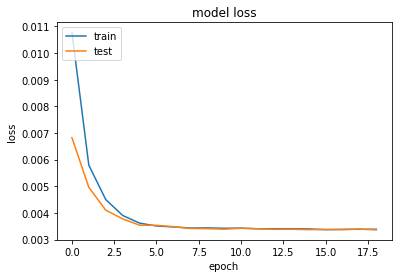

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [29]:
import matplotlib.pyplot as plt
def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1))

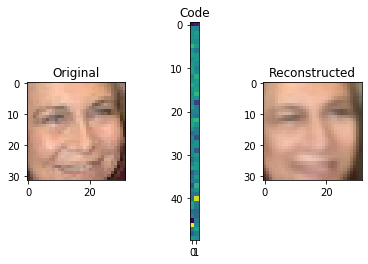

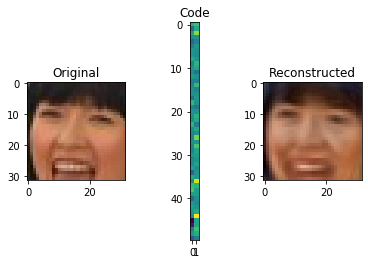

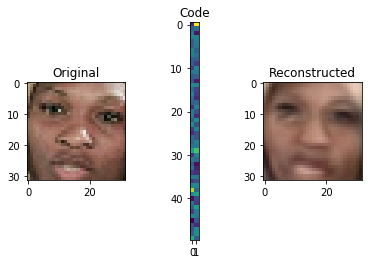

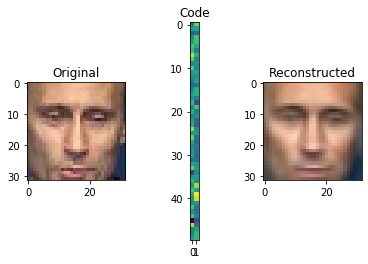

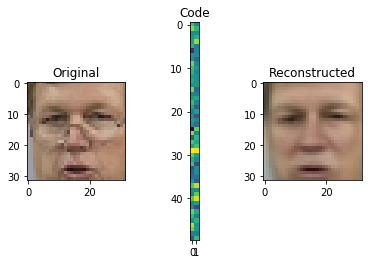

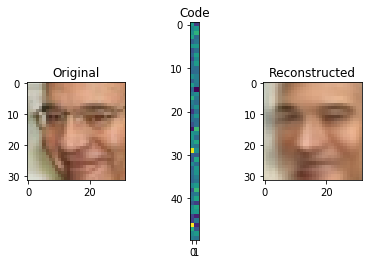

In [30]:
def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    # img[None] will have shape of (1, 32, 32, 3) which is the same as the model input
    code = encoder.predict(img[None])[0]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
    plt.show()

for i in range(6):
    img = X_test[i]
    visualize(img,encoder,decoder)